In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pathlib import Path
import pickle
import itertools
from IPython.display import Image

In [3]:
from mmfitting import crossval_summarize_mm

In [4]:
%matplotlib inline

# Prelude to assessing fits

Before assessing model fits, it is assumed that the following has already occured:

* simulation scenarios file has been created and uses same column names as `exp10_obflow06_metainputs.csv`
* `obsimpy.create_configs.py` run using scenarios file to create yaml config files for simulation runs. In addition to the
YAML config files, a bash script is created with the python commands for running the simulation model for each scenario.
* obflow_06 simulation runs have been completed and occ and stop log files and occ stat files are created
* `obsimpy.obflow_06_output.py` has been run to process the logs and create the main summary files:
    - `scenario_rep_simout_{suffix}.csv` - sim outputs by scenario by rep (NO inputs)
    - `scenario_rep_siminout_{suffix}.csv` - sim inputs and outputs by scenario by rep
    - `scenario_simout_{suffix}.csv` - sim outputs by scenario (NO inputs)
    
Then we need to run `dataprep.py` from the `mm_interpret` project. It has a simple CLI or you can override and run directly. It will:

* Create `scenario_siminout_qng_{suffix}.csv` - sim inputs, outputs and queueing approximations by scenario
* Create all the X and y csv files for model fitting.

Now we are ready for model fitting using the `mm_interpret` project. The following scripts do **NOT** have CLI's implemented. Instead we have to set some variable values manually:

    experiment = "exp11"
    data_path = Path("data")
    output_path = Path("output")
    figures_path = Path("output", "figures")
    raw_data_path = Path("data", "raw")
    pickle_filename = f"ldr_results_{experiment}.pkl"

* `run_mm_fits_ldr.py` --> `ldr_results_exp11.pkl`
* `run_mm_fits_pp.py` --> `pp_results_exp11.pkl`
* `run_mm_fits_obs.py` --> `obs_results_exp11.pkl`


The pickle files contain the fitting model objects. Now we can use those model objects to create actual vs predicted plot for each model. Use `process_fitted_models.py`.

> **IMPORTANT NOTE** Exp11 was rerun without the infinite capacity scenarios as they represent values of rho which are far outside the range of values used in the finite capacity scenarios (~.5 to ~.8). After debugging the exp11 results to make sure everything being computed correctly, perhaps we should run an experiment with a wider and more uniform range of rho values. Specify rho instead of using overflow target approximations.

In [5]:
output_path = "output"

obs_pkl_filename =  "obs_results_exp11.pkl"
ldr_pkl_filename =  "ldr_results_exp11.pkl"
pp_pkl_filename =  "pp_results_exp11.pkl"

obs_pkl_path = Path(output_path, obs_pkl_filename)
ldr_pkl_path = Path(output_path, ldr_pkl_filename)
pp_pkl_path = Path(output_path, pp_pkl_filename)

## PP results
Starting here since no downstream units to block patients and no LOS adjustments due to blocking.

In [6]:
with open(pp_pkl_path, 'rb') as pickle_file:
    pp_results = pickle.load(pickle_file)

The keys are the models fitted.

In [7]:
pp_results.keys()

dict_keys(['pp_occ_mean_basicq_lm_results', 'pp_occ_mean_noq_lm_results', 'pp_occ_mean_basicq_lassocv_results', 'pp_occ_mean_noq_lassocv_results', 'pp_occ_mean_basicq_poly_results', 'pp_occ_mean_noq_poly_results', 'pp_occ_mean_basicq_rf_results', 'pp_occ_mean_noq_rf_results', 'pp_occ_mean_basicq_svr_results', 'pp_occ_mean_noq_svr_results', 'pp_occ_mean_basicq_nn_results', 'pp_occ_mean_noq_nn_results', 'pp_occ_mean_onlyq_lm_results', 'pp_occ_p95_basicq_lm_results', 'pp_occ_p95_noq_lm_results', 'pp_occ_p95_basicq_lassocv_results', 'pp_occ_p95_noq_lassocv_results', 'pp_occ_p95_basicq_poly_results', 'pp_occ_p95_noq_poly_results', 'pp_occ_p95_basicq_rf_results', 'pp_occ_p95_noq_rf_results', 'pp_occ_p95_basicq_svr_results', 'pp_occ_p95_noq_svr_results', 'pp_occ_p95_basicq_nn_results', 'pp_occ_p95_noq_nn_results', 'pp_occ_mean_basicq_load_results', 'pp_occ_p95_basicq_sqrtload_results', 'pp_occ_mean_basicq_hgbr_results', 'pp_occ_p95_basicq_hgbr_results', 'pp_occ_p95_onlyq_lm_results'])

### PP mean occupancy

#### lm and lassocv

Let's start here as they are simplest.

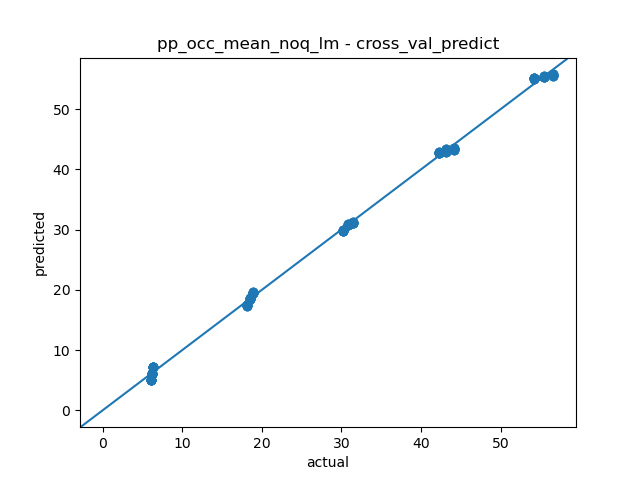

In [8]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

Linear model with noq does pretty well. What if we add the basicq fields? The queueing fields definitely help.

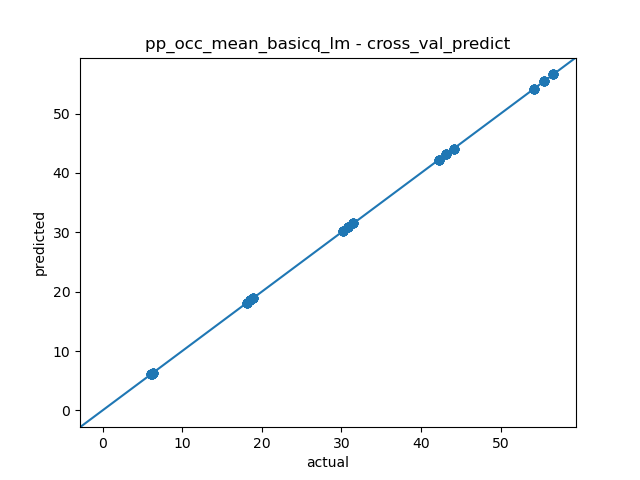

In [9]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

What do the coefficients look like?

Look pretty stable though some things don't make physics sense such as negative coeffs on `mean_los_pp` and `c_sect_prob`. Let's see if the lasso models can help with this issue.

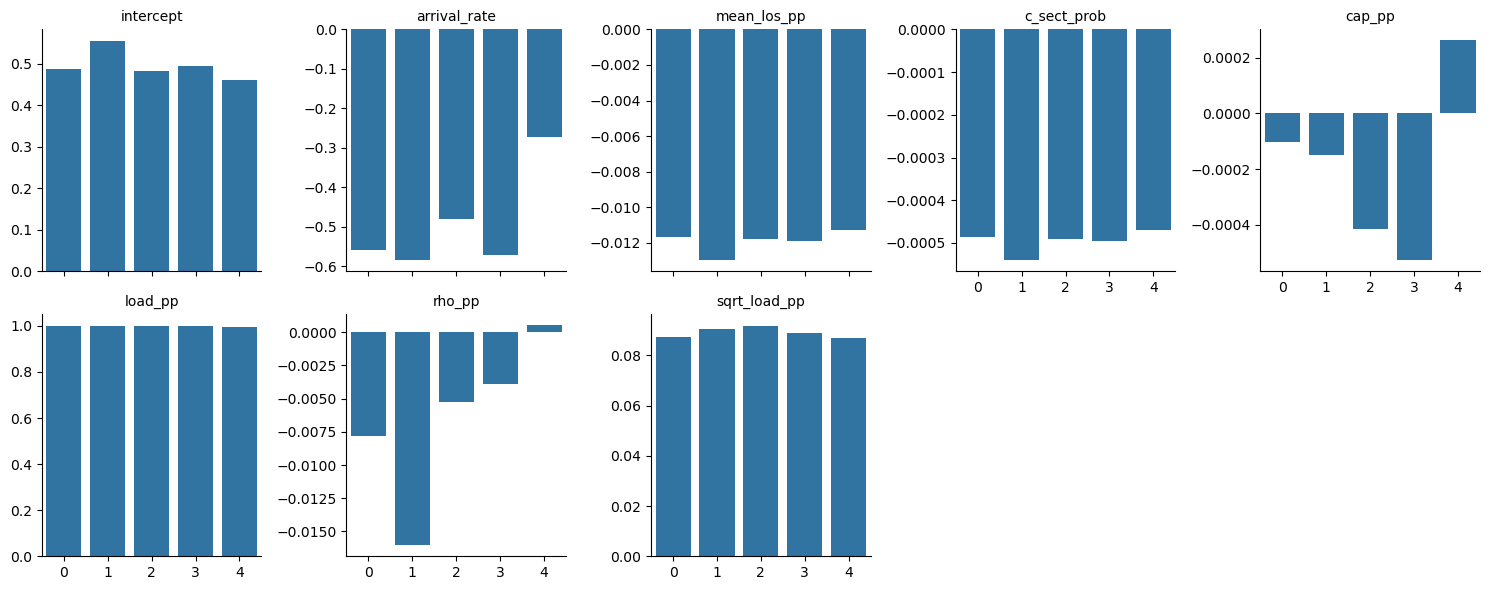

In [10]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_lm_cv_coeff.png")
Image(filename=figures_path) 

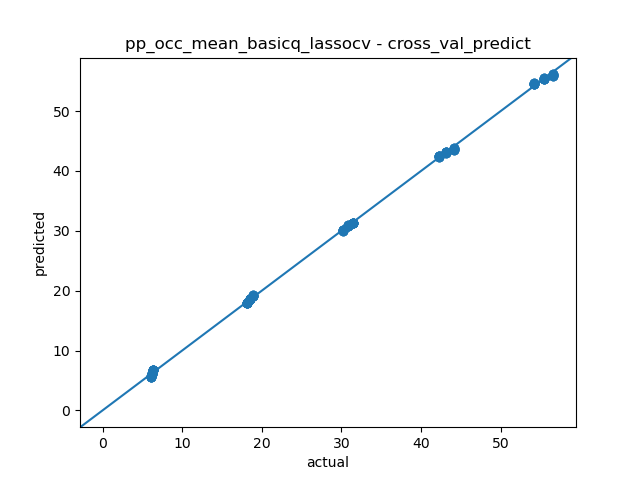

In [11]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_lassocv_cv_scatter.png")
Image(filename=figures_path) 

Fit seems intermediate between noq and basicq.

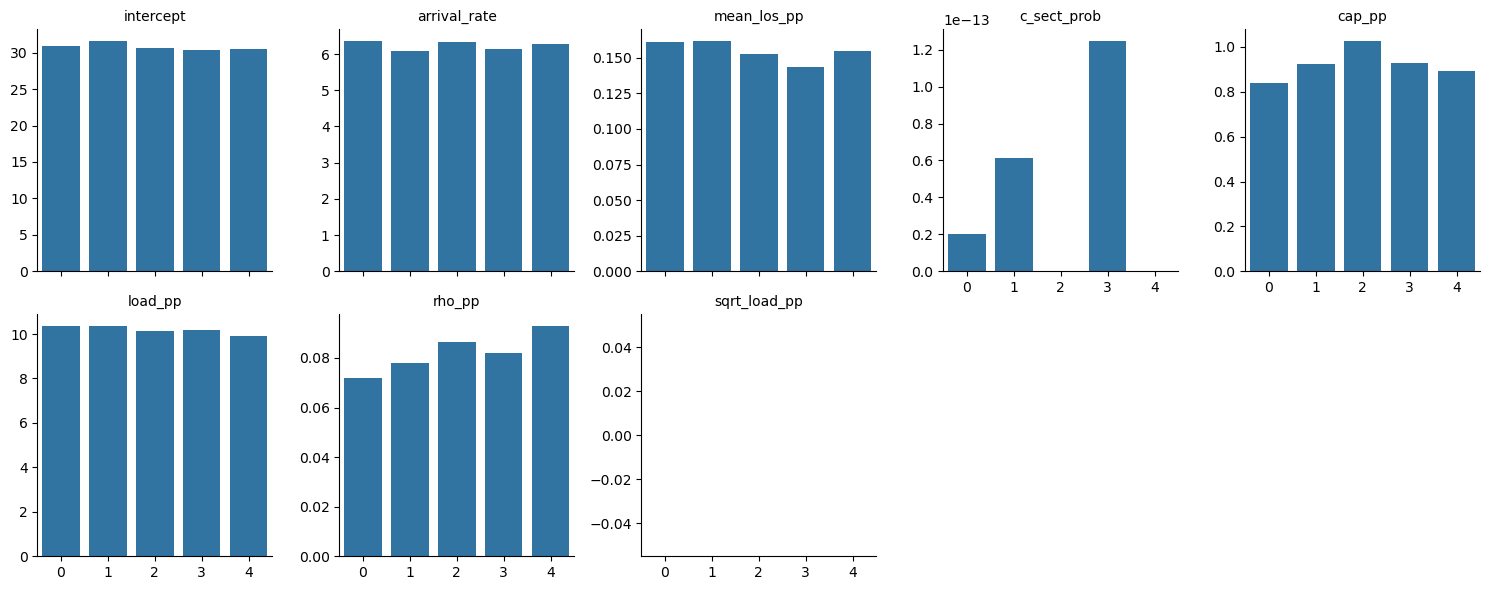

In [12]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_lassocv_cv_coeff.png")
Image(filename=figures_path) 

Driving the `sqrt_load_pp` term to 0 makes sense since mean occ should not depend on this. This has the desirable effect of all of the other coefficients having signs that make sense.

#### poly

Widely used, so let's see how it did.

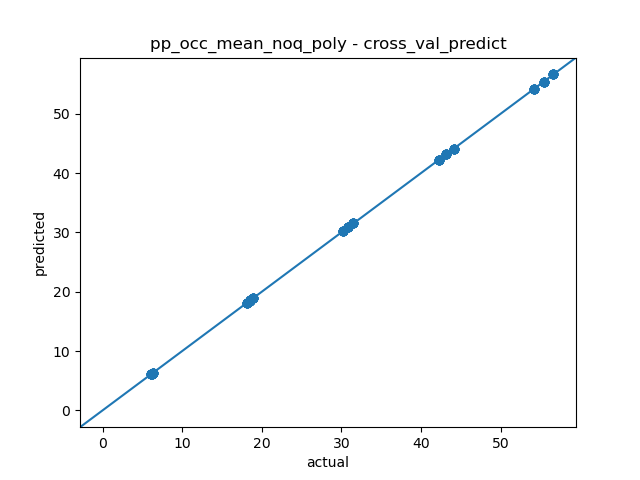

In [13]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_poly_cv_scatter.png")
Image(filename=figures_path) 

The poly model fits very well even with no qng terms.

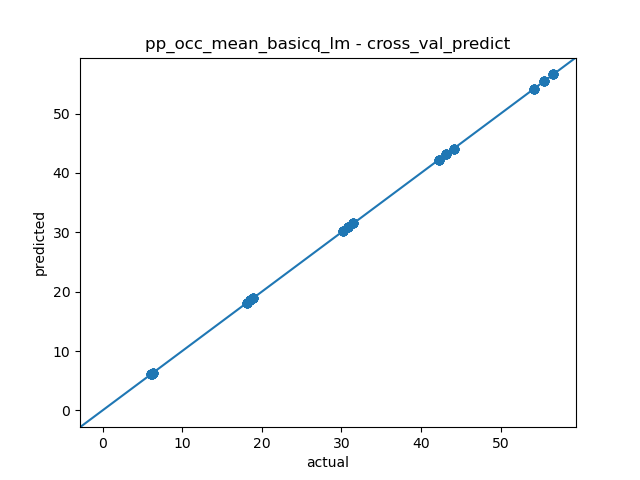

In [14]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

What about the coeffs?

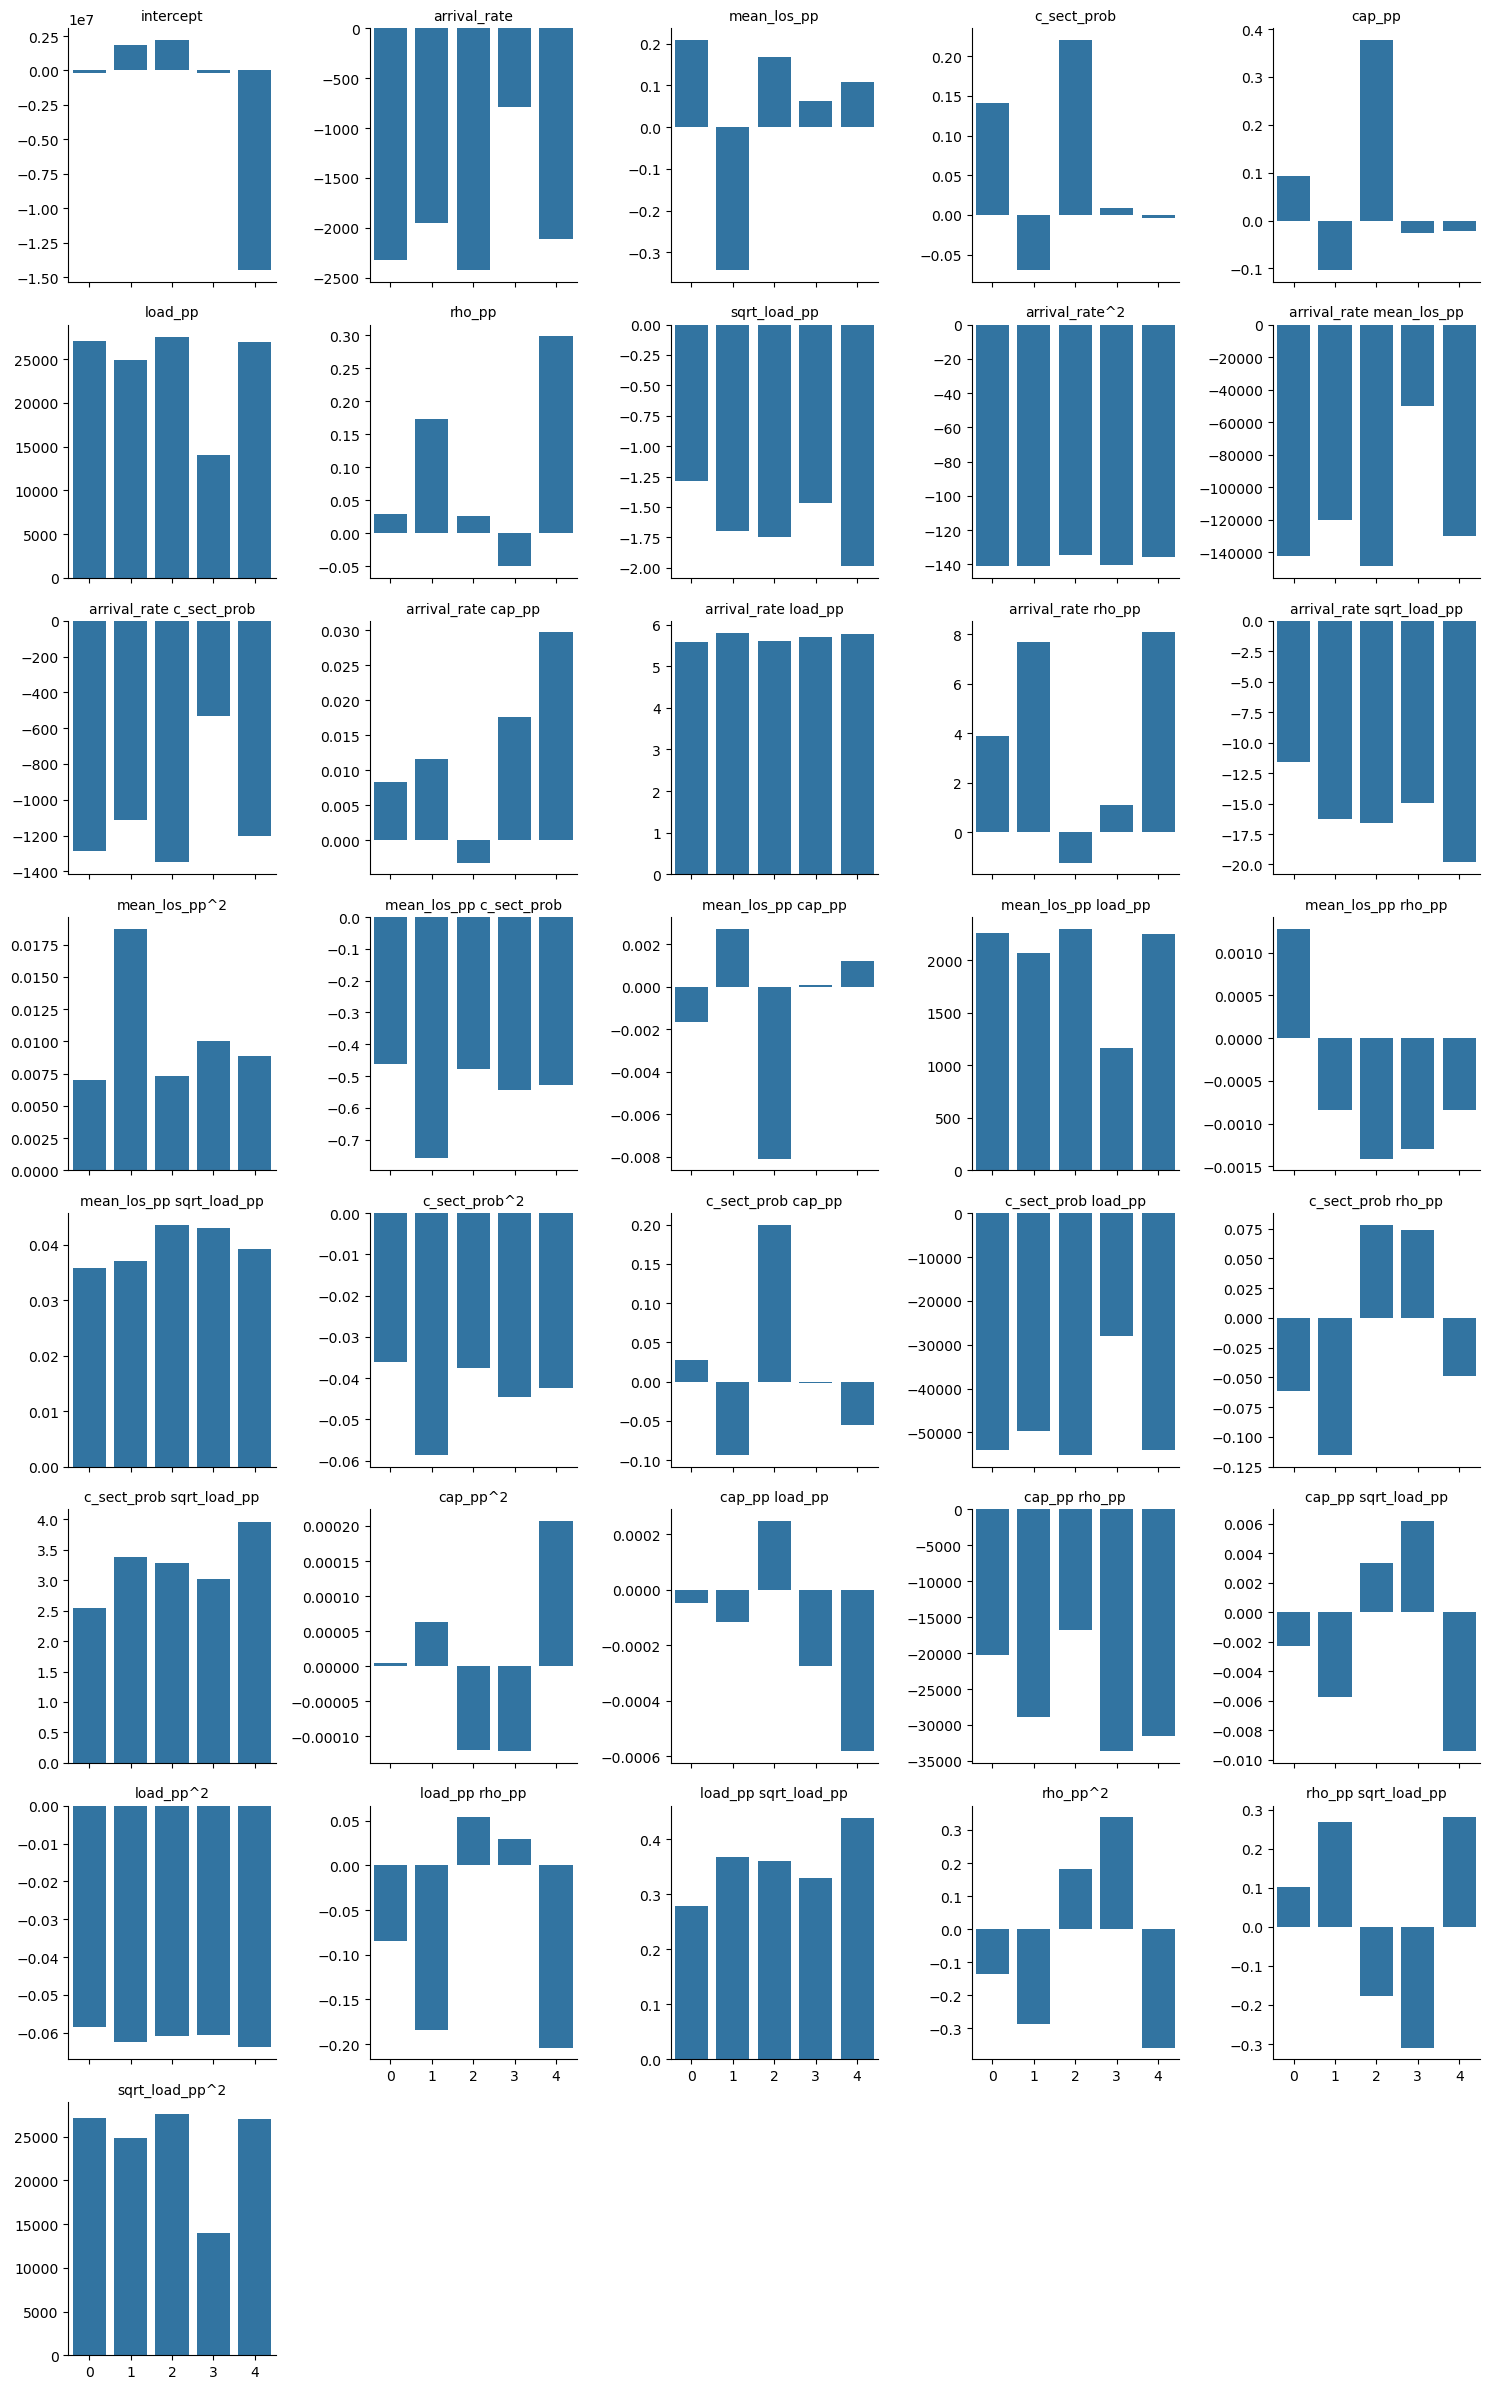

In [15]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_poly_cv_coeff.png")
Image(filename=figures_path) 

Many variables. Some troubling sign swapping and overall coeff instability. Let's check for the noq version - at least there will be less variables.

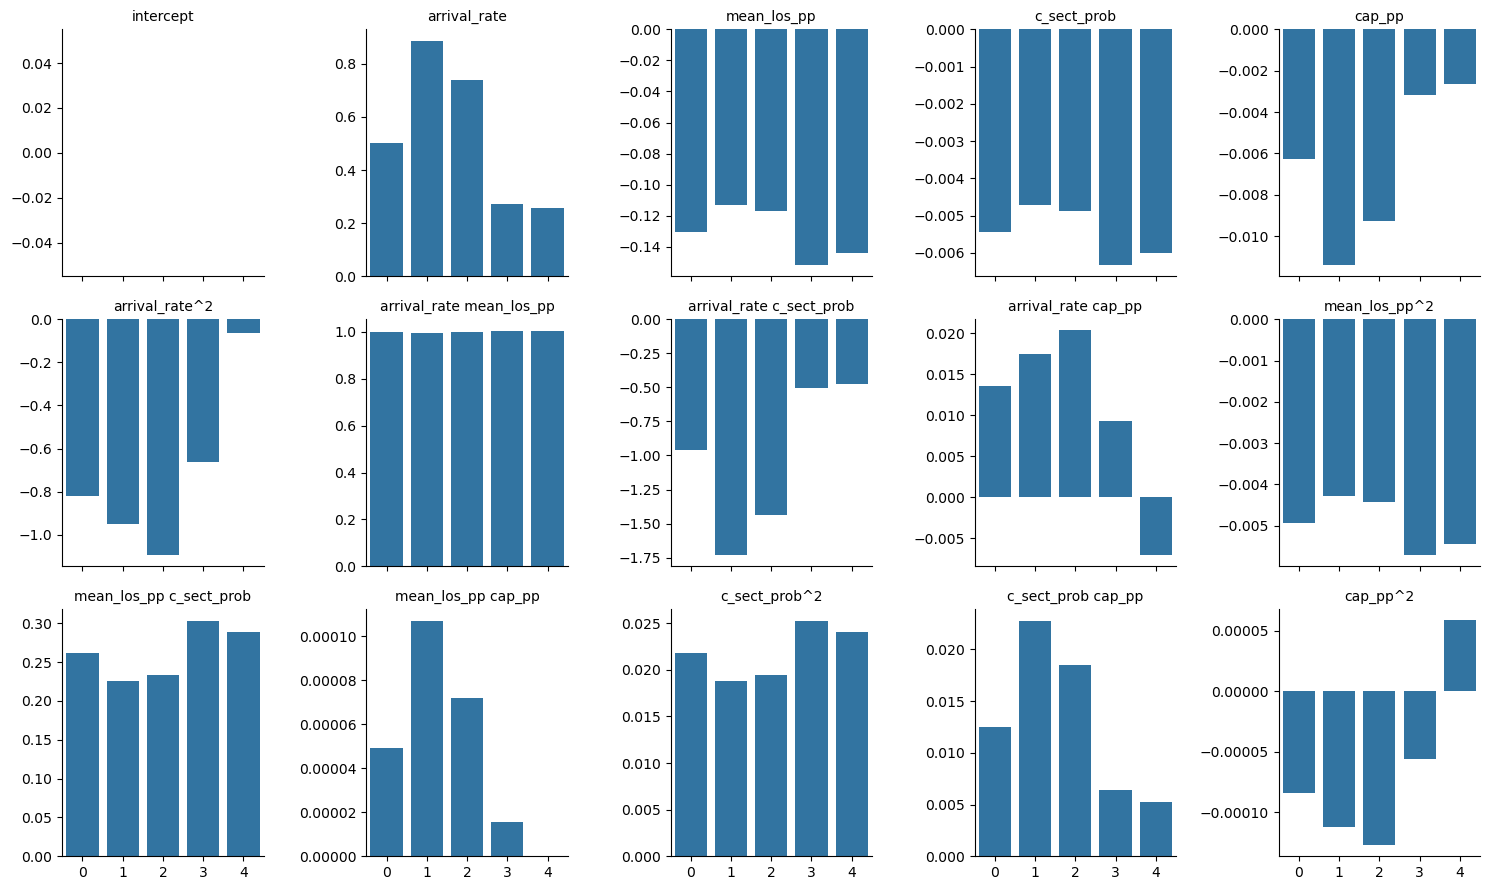

In [16]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_poly_cv_coeff.png")
Image(filename=figures_path) 

Less sign swapping and more stable. Seems like many negative coefficients to offset the positive ones. Hard to explain.

#### The ML models - rf, nn, svr

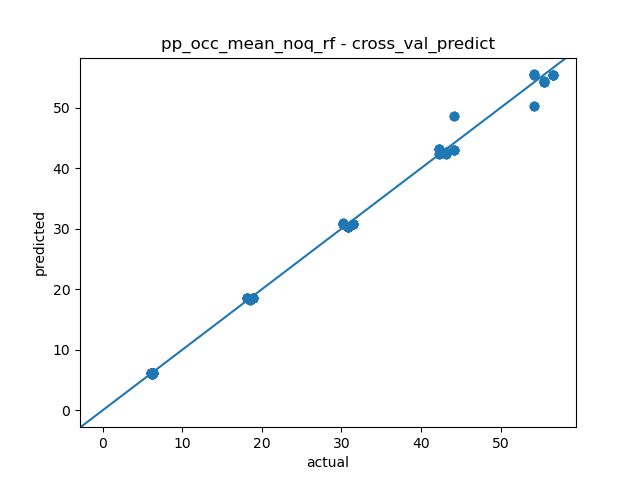

In [17]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_rf_cv_scatter.png")
Image(filename=figures_path) 

Not as good as the linear models, especially at upper end of occupancy levels.

Do qnq terms help? Yes, they appear to help a bit.

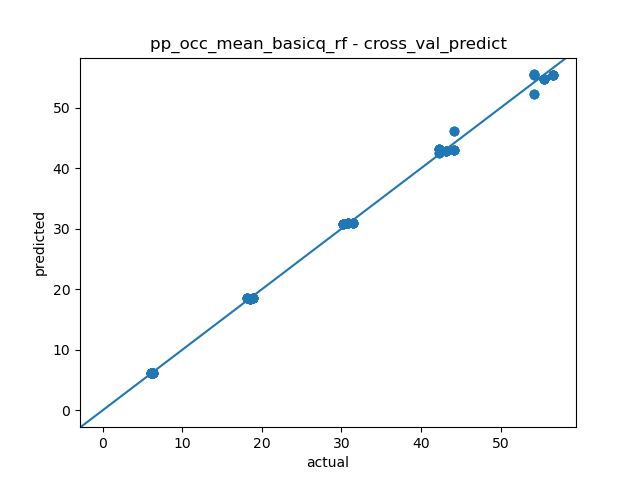

In [18]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_rf_cv_scatter.png")
Image(filename=figures_path) 

Let's look at the metrics themselves.

In [19]:
pp_results['pp_occ_mean_noq_rf_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.268119                   0.145077   
1                  0.170126                   0.150913   
2                  0.180017                   0.145570   
3                  0.813725                   0.148236   
4                  0.356460                   0.144046   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.008520                              0.004283   
1                             0.006800                              0.004639   
2                             0.005773                              0.004706   
3                             0.020088                              0.004714   
4                             0.009201                              0.004552   

    test_r2  train_r2  
0  0.999553  0.999859  
1  0.999839  0.999867  
2  0.999853  0.999900  
3  0.988130  0.999860  
4  0.998856  0.999764

In [20]:
pp_results['pp_occ_mean_basicq_rf_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.241505                   0.133642   
1                  0.156313                   0.116935   
2                  0.174310                   0.130487   
3                  0.493427                   0.138427   
4                  0.202689                   0.123350   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.007674                              0.003909   
1                             0.006264                              0.003884   
2                             0.005582                              0.004321   
3                             0.012668                              0.004304   
4                             0.006201                              0.004059   

    test_r2  train_r2  
0  0.999626  0.999872  
1  0.999876  0.999927  
2  0.999861  0.999916  
3  0.996673  0.999868  
4  0.999814  0.999901

Now for the neural nets. Overall, they perform poorly and if the qng terms help, it's not much.

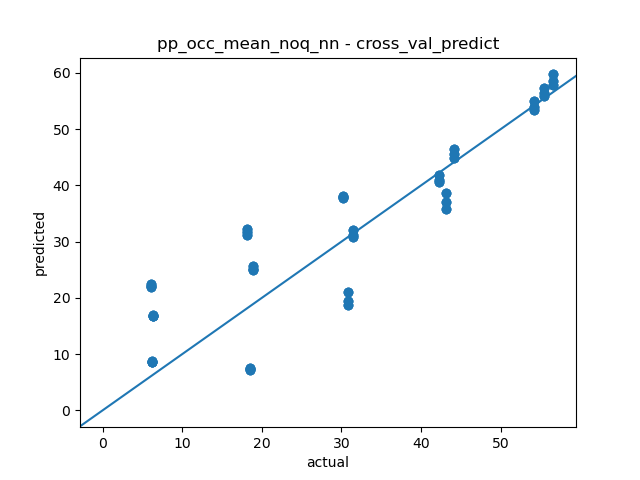

In [21]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_nn_cv_scatter.png")
Image(filename=figures_path) 

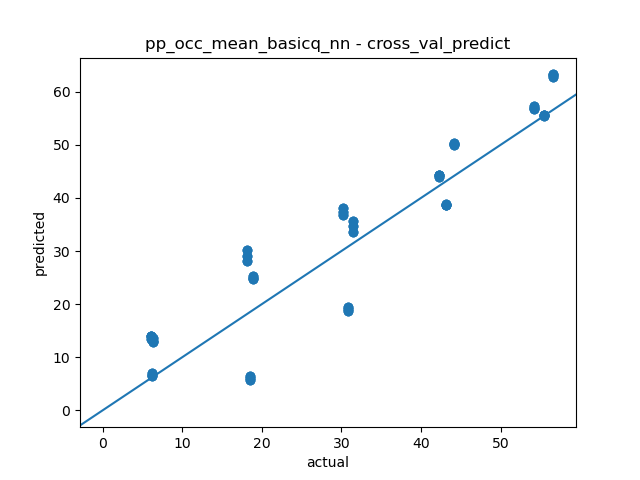

In [22]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_nn_cv_scatter.png")
Image(filename=figures_path) 

Finally, let's look at the svrs. Overall, they perform poorly and if the qng terms help, it's not much.

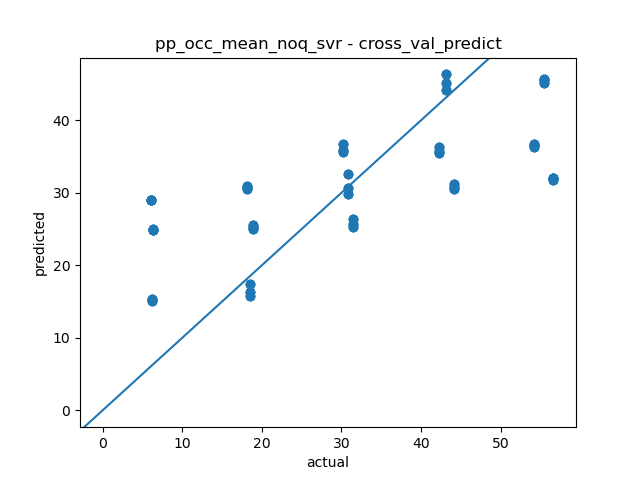

In [23]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_svr_cv_scatter.png")
Image(filename=figures_path) 

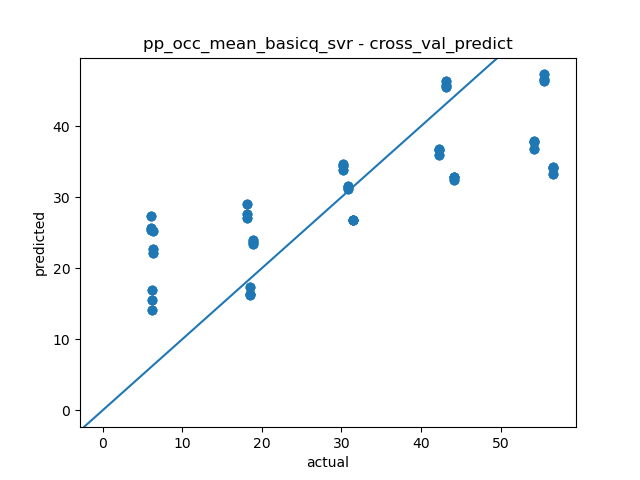

In [24]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_svr_cv_scatter.png")
Image(filename=figures_path) 

#### load
This uses the offered load as the estimate for mean occupancy. There is **no** model "fitting". It should perform well as it's really just Little's Law.

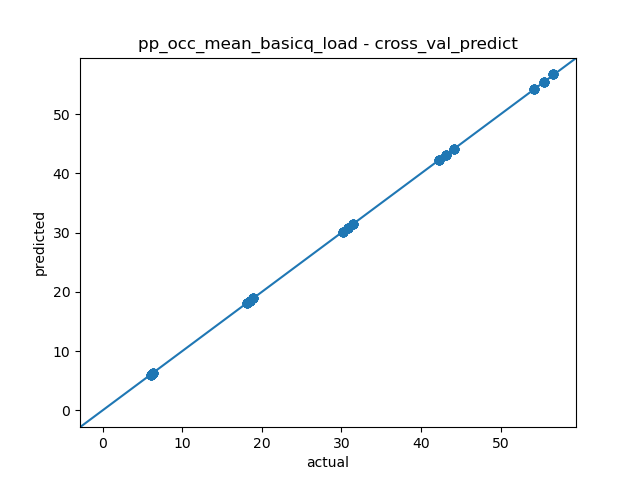

In [25]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_load_cv_scatter.png")
Image(filename=figures_path) 

Now look at "fitted" version of above queueing approximation using within an lm.

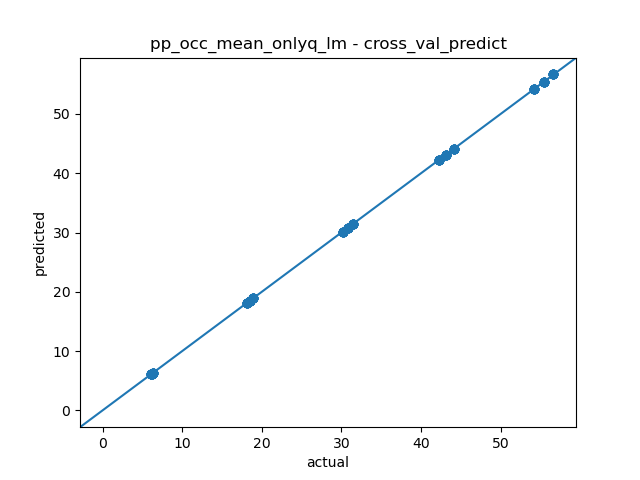

In [26]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_onlyq_lm_cv_scatter.png")
Image(filename=figures_path) 

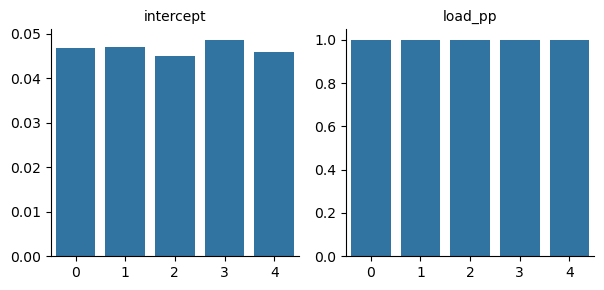

In [27]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_onlyq_lm_cv_coeff.png")
Image(filename=figures_path) 

In [28]:
pp_results['pp_occ_mean_onlyq_lm_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.029903                   0.023320   
1                  0.025152                   0.024259   
2                  0.020143                   0.025339   
3                  0.025961                   0.024184   
4                  0.021741                   0.024857   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.001760                              0.001405   
1                             0.001734                              0.001408   
2                             0.001110                              0.001510   
3                             0.001530                              0.001505   
4                             0.001231                              0.001498   

    test_r2  train_r2  
0  0.999996  0.999998  
1  0.999997  0.999998  
2  0.999998  0.999997  
3  0.999997  0.999998  
4  0.999998  0.999997

In [29]:
pp_results['pp_occ_mean_basicq_load_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.030399                   0.029675   
1                  0.028740                   0.030090   
2                  0.030494                   0.029651   
3                  0.026432                   0.030667   
4                  0.033033                   0.029016   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.001148                              0.001127   
1                             0.001254                              0.001101   
2                             0.001078                              0.001145   
3                             0.000992                              0.001166   
4                             0.001184                              0.001118   

    test_r2  train_r2  
0  0.999994  0.999995  
1  0.999994  0.999994  
2  0.999994  0.999995  
3  0.999995  0.999994  
4  0.999994  0.999994

In [30]:
pp_results['pp_occ_mean_basicq_poly_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.000819                   0.000535   
1                  0.000689                   0.000547   
2                  0.000740                   0.000497   
3                  0.000858                   0.000501   
4                  0.000721                   0.000679   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.000028                              0.000018   
1                             0.000025                              0.000019   
2                             0.000025                              0.000016   
3                             0.000026                              0.000017   
4                             0.000025                              0.000028   

   test_r2  train_r2  
0      1.0       1.0  
1      1.0       1.0  
2      1.0       1.0  
3      1.0       1.0  
4      1.0       1.0

In [31]:
pp_results['pp_occ_mean_noq_poly_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.007093                   0.007014   
1                  0.007015                   0.006948   
2                  0.007753                   0.006840   
3                  0.008800                   0.006548   
4                  0.007689                   0.007401   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.000386                              0.000375   
1                             0.000358                              0.000358   
2                             0.000375                              0.000347   
3                             0.000510                              0.000343   
4                             0.000372                              0.000387   

   test_r2  train_r2  
0      1.0       1.0  
1      1.0       1.0  
2      1.0       1.0  
3      1.0       1.0  
4      1.0       1.0

In [32]:
pp_results['pp_occ_mean_noq_lm_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.240006                   0.229669   
1                  0.259639                   0.226447   
2                  0.236460                   0.235563   
3                  0.231093                   0.234759   
4                  0.253265                   0.225483   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.022369                              0.014758   
1                             0.022319                              0.015124   
2                             0.012127                              0.015974   
3                             0.011151                              0.015791   
4                             0.012956                              0.015505   

    test_r2  train_r2  
0  0.999666  0.999720  
1  0.999668  0.999714  
2  0.999659  0.999723  
3  0.999693  0.999713  
4  0.999714  0.999708

In [33]:
pp_results['pp_occ_mean_basicq_lm_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.009081                   0.009300   
1                  0.009267                   0.009460   
2                  0.009965                   0.009234   
3                  0.011934                   0.008370   
4                  0.008509                   0.009350   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.000259                              0.000334   
1                             0.000360                              0.000355   
2                             0.000382                              0.000331   
3                             0.000447                              0.000296   
4                             0.000314                              0.000326   

    test_r2  train_r2  
0  0.999999  1.000000  
1  0.999999  1.000000  
2  0.999999  1.000000  
3  0.999999  1.000000  
4  1.000000  0.999999

**BOTTOM LINE - PP occmean** While many of the models fit well, the qng terms lead to superior fits. The ML models are easily the worst. This set of scenarios is arguably the easiest to predict since no upstream or downstream units affect the load and the performance is a very simple measure.

The models based on queueing approximations or lm's using queueing approximations are very parsimonious, very accurate, and have coefficients that make sense and are stable across folds. The errors are pretty similar across folds as well. The lm and poly models that fit well have some strange coeff signs and variability across folds though their errors across folds have low variability.

### PP 95%ile occupancy

#### lm and lassocv

Let's start here as they are simplest.

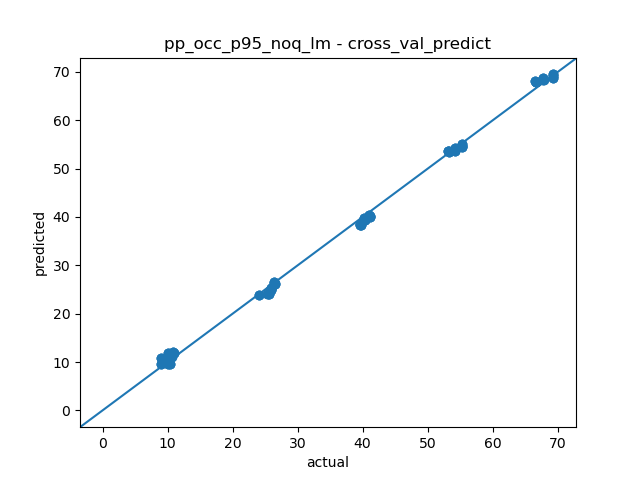

In [34]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

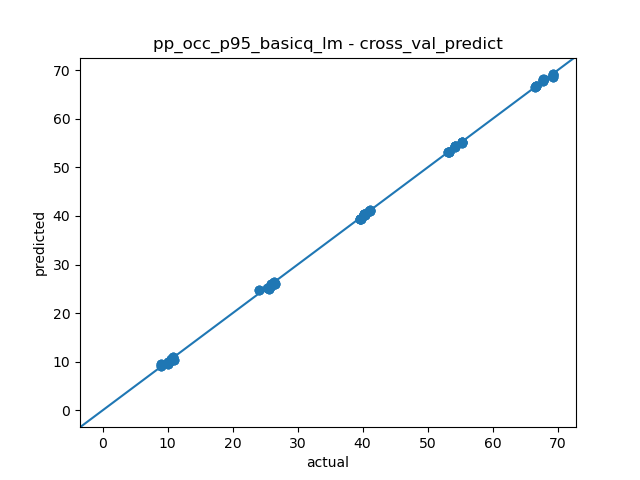

In [35]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

All fits are pretty good but queueing terms help a bit.

What do the coefficients look like?

Look pretty stable though some things don't make physics sense such as negative coeffs on `rho_pp` Let's see if the lasso models can help with this issue.

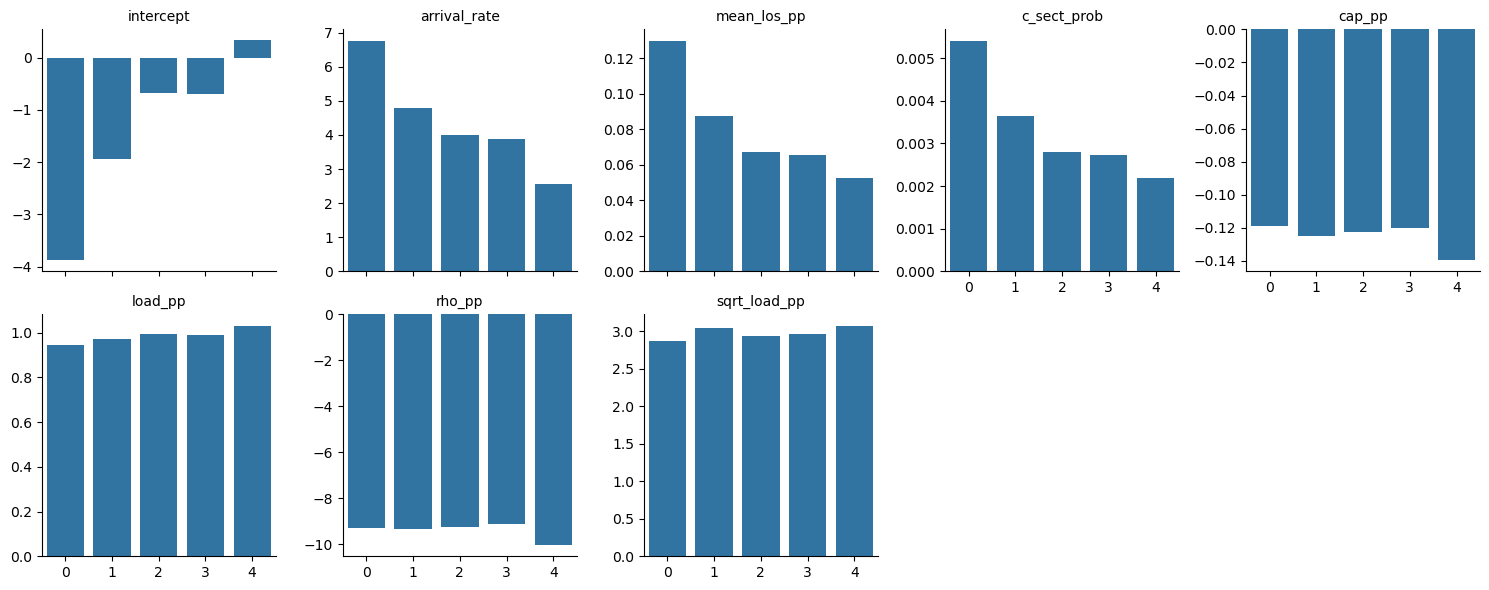

In [36]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_lm_cv_coeff.png")
Image(filename=figures_path) 

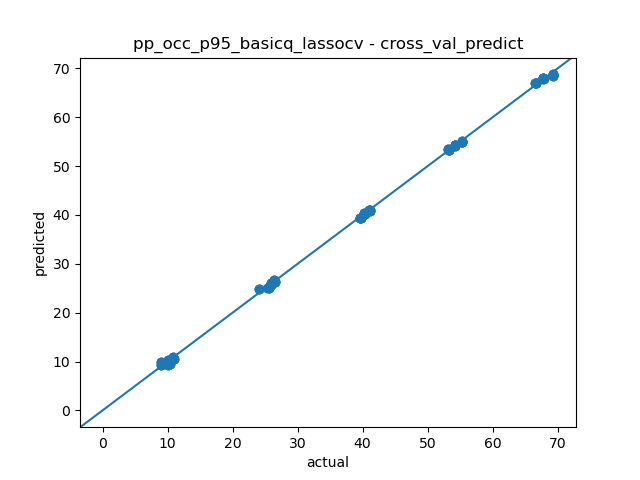

In [37]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_lassocv_cv_scatter.png")
Image(filename=figures_path) 

Fit seems intermediate between noq and basicq.

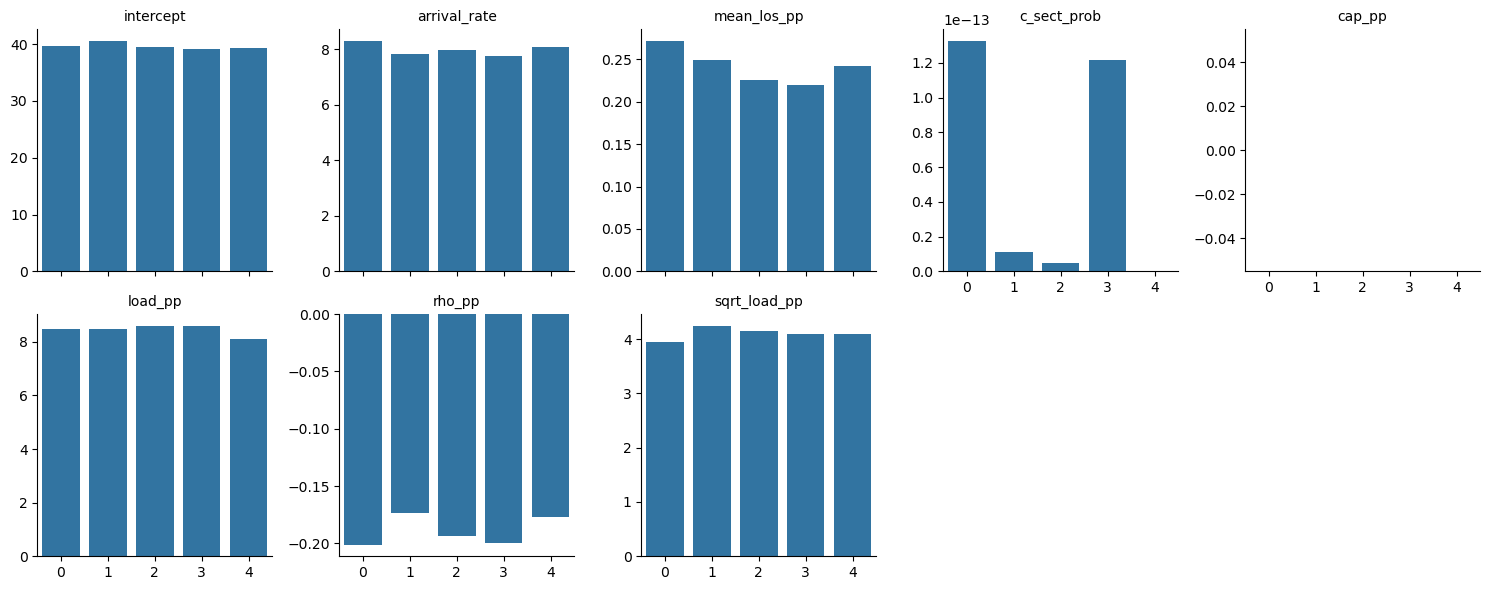

In [38]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_lassocv_cv_coeff.png")
Image(filename=figures_path) 

Having the `sqrt_load_pp` term > 0 makes sense since p95 occ should depend on this. However, `rho_pp` is still negative.

#### poly p95

Widely used, so let's see how it did.

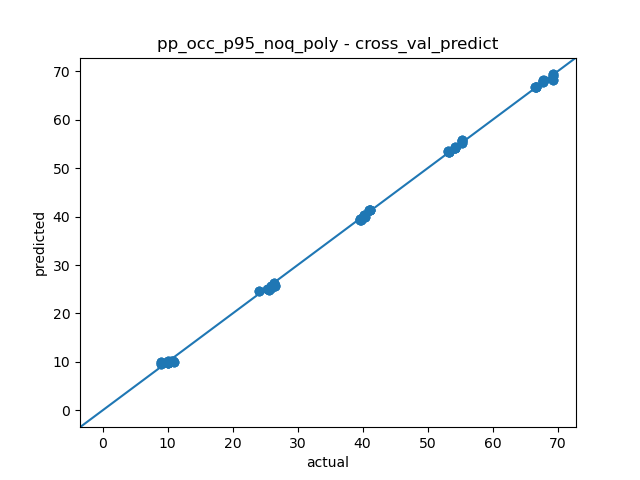

In [39]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_poly_cv_scatter.png")
Image(filename=figures_path) 

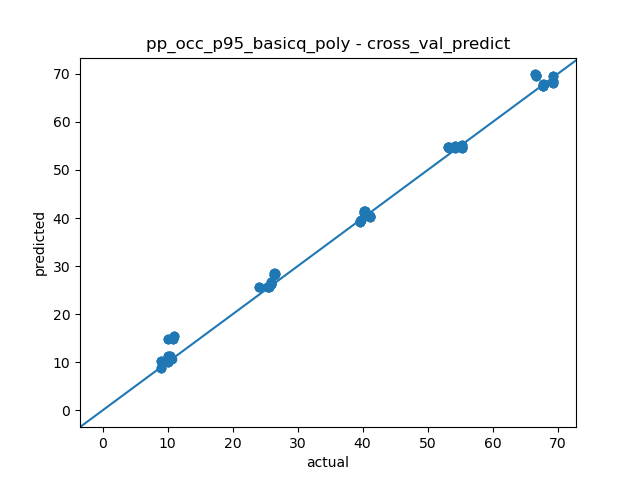

In [40]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_poly_cv_scatter.png")
Image(filename=figures_path) 

Interestingly, the noq fits better than basicq. Is this overfitting? But, looking at metrics df's, basicq fits better. Is this possible? 

Yes, seems like this is related to difference between `cross_val_score` (equivalently, `cross_validate` which I use so that I can use multiple scoring metrics) and `cross_val_predict`. See, for example, https://stackoverflow.com/questions/55009704/why-is-cross-val-predict-not-appropriate-for-measuring-the-generalisation-error. This is also discussed in the sklearn docs. In a nutshell, `cross_validate` reports scores averaged over folds and `cross_val_predict` simply provides prediction for each data point when it was in the test set. Computing the error metric based on these predictions and the actuals does not necessarily equate to the averages over folds (data can end up being grouped differently and the measures might not be linear in sense that average of averages is not same as average over entire set).

In [41]:
pp_results['pp_occ_p95_noq_poly_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.289614                   0.227126   
1                  0.300796                   0.242386   
2                  0.234634                   0.239057   
3                  0.278099                   0.238646   
4                  0.263129                   0.245900   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.015260                              0.011074   
1                             0.015451                              0.011639   
2                             0.011517                              0.012349   
3                             0.013232                              0.012116   
4                             0.011040                              0.012317   

    test_r2  train_r2  
0  0.999656  0.999772  
1  0.999645  0.999779  
2  0.999730  0.999764  
3  0.999724  0.999761  
4  0.999754  0.999749

In [42]:
pp_results['pp_occ_p95_basicq_poly_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.125703                   0.097063   
1                  0.124805                   0.073510   
2                  0.134156                   0.080573   
3                  0.102854                   0.098904   
4                  0.119539                   0.127305   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.005791                              0.003858   
1                             0.005468                              0.002863   
2                             0.004647                              0.003363   
3                             0.005044                              0.003940   
4                             0.003691                              0.004845   

    test_r2  train_r2  
0  0.999927  0.999960  
1  0.999907  0.999972  
2  0.999924  0.999969  
3  0.999960  0.999960  
4  0.999951  0.999915

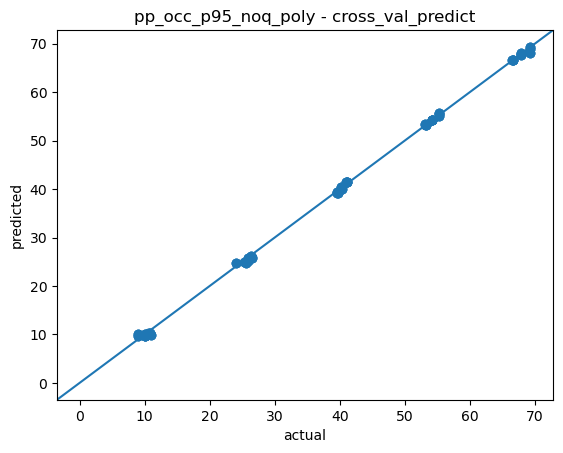

In [43]:
pp_results['pp_occ_p95_noq_poly_results']['fitplot']

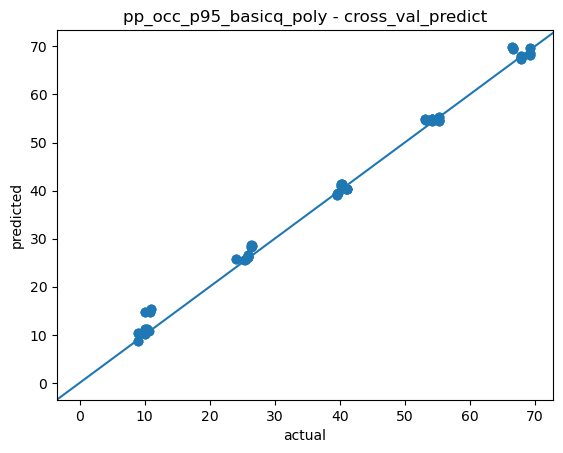

In [44]:
pp_results['pp_occ_p95_basicq_poly_results']['fitplot']

No, the plots don't appear to have been switched. How exactly are the values in the metrics_df's computed? I would think that the plots are just visualizations of the errors in the test data for each fold - they are (see discussion above).

In [45]:
pp_results['pp_occ_p95_basicq_poly_results'].keys()

dict_keys(['scenario', 'measure', 'flavor', 'unit', 'model', 'coeffs_df', 'metrics_df', 'scaling', 'scaled_coeffs_df', 'alphas', 'predictions', 'residuals', 'fitplot', 'coefplot'])

In [46]:
pp_results['pp_occ_p95_basicq_poly_results']['residuals']

scenario
1      0.915148
2      1.211899
3      1.300308
4      0.881815
5      1.211899
         ...   
131   -0.753571
132   -1.177911
133    0.314917
134   -0.720238
135   -1.177911
Name: occ_mean_p95_pp, Length: 135, dtype: float64

In [47]:
abs(pp_results['pp_occ_p95_basicq_poly_results']['residuals']).mean()

1.1598602488011458

In [48]:
abs(pp_results['pp_occ_p95_noq_poly_results']['residuals']).mean()

0.3526347354744561

I know this can happen but it's troubling.

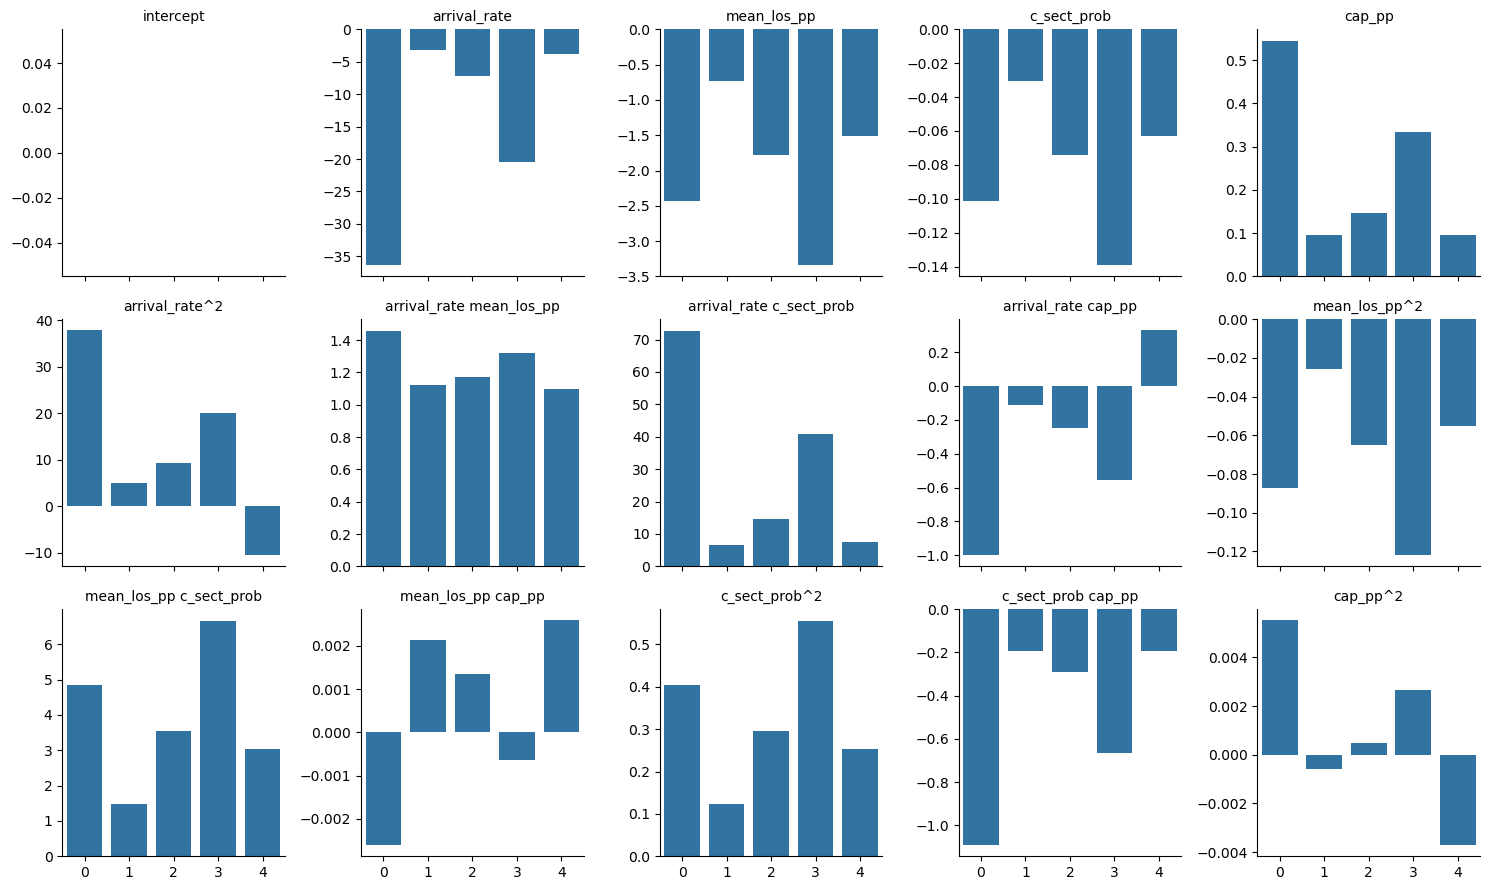

In [49]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_poly_cv_coeff.png")
Image(filename=figures_path) 

Getting some sign swapping and unstable coeffs.

#### The ML models - rf, nn, svr

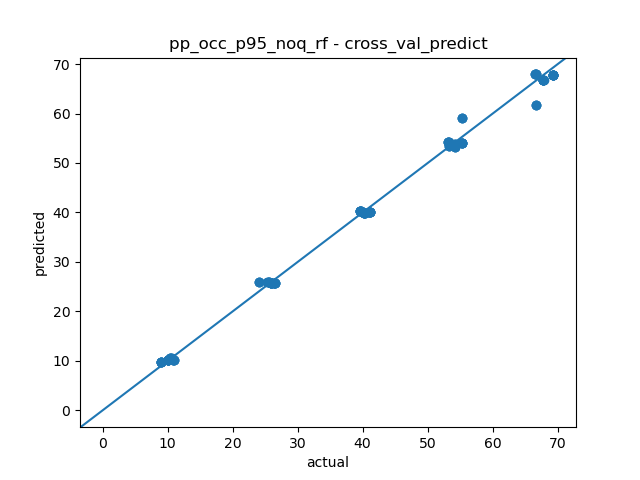

In [50]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_rf_cv_scatter.png")
Image(filename=figures_path) 

Not as good as the linear models, especially at upper end of occupancy levels.

Do qnq terms help? Yes, they appear to help a bit.

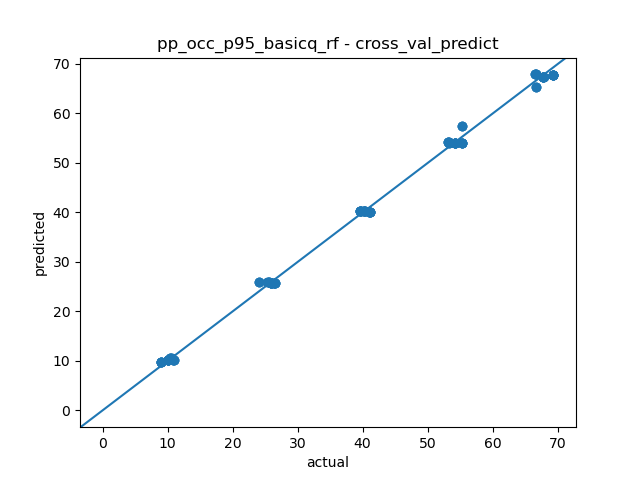

In [51]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_rf_cv_scatter.png")
Image(filename=figures_path) 

Now for the neural nets. Overall, they perform poorly and if the qng terms help, it's not much.

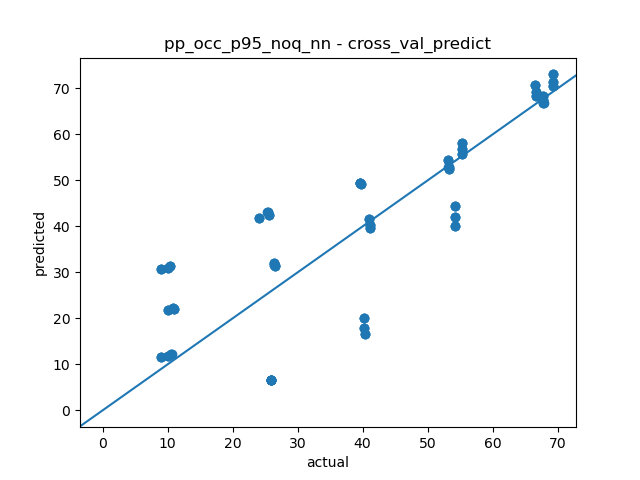

In [52]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_nn_cv_scatter.png")
Image(filename=figures_path) 

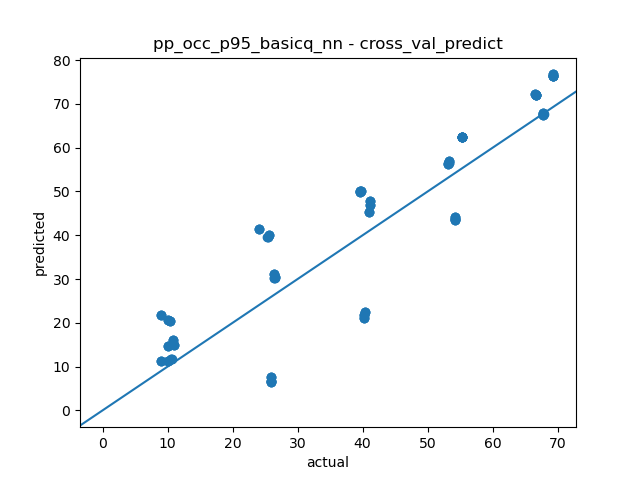

In [53]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_nn_cv_scatter.png")
Image(filename=figures_path) 

Finally, let's look at the svrs. Overall, they perform poorly and if the qng terms help, it's not much.

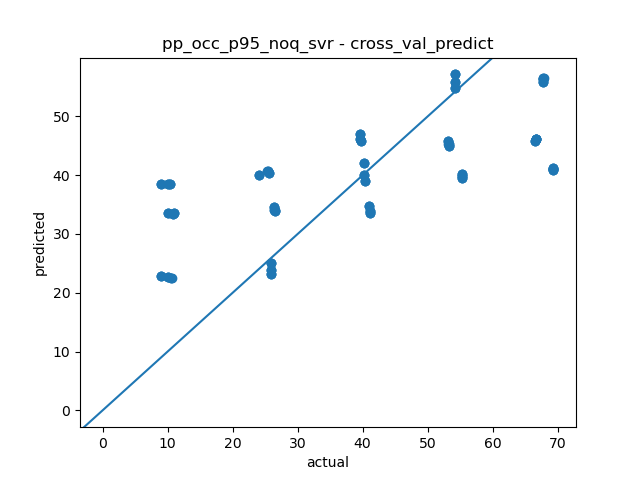

In [54]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_svr_cv_scatter.png")
Image(filename=figures_path) 

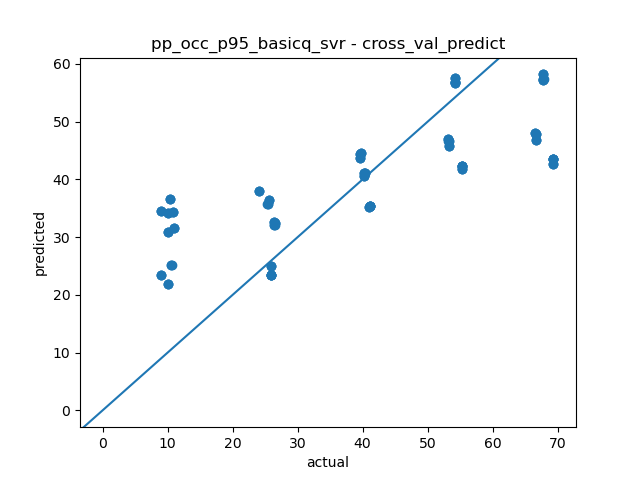

In [55]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_svr_cv_scatter.png")
Image(filename=figures_path) 

#### sqrt load
This uses the square root formula as the estimate for p95 occupancy. There is **no** model "fitting". 

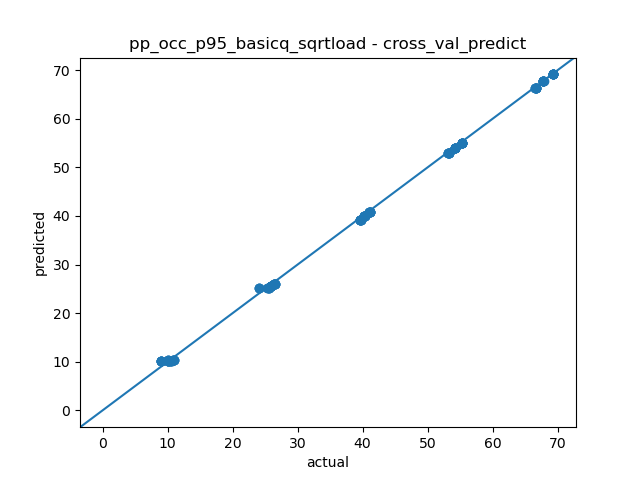

In [56]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_sqrtload_cv_scatter.png")
Image(filename=figures_path) 

Now look at "fitted" version of above queueing approximation using within an lm.

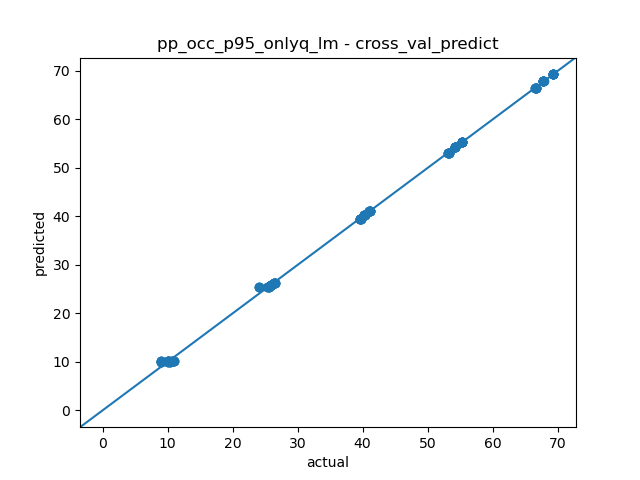

In [57]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_onlyq_lm_cv_scatter.png")
Image(filename=figures_path) 

In [58]:
pp_results['pp_occ_p95_onlyq_lm_results']['coeffs_df']

intercept   load_pp  sqrt_load_pp
0  -0.895107  0.964949      2.051166
1  -1.467458  0.945267      2.274196
2  -1.259268  0.951616      2.198651
3  -1.233287  0.950983      2.199603
4  -1.247083  0.954001      2.179854

In [59]:
pp_results['pp_occ_p95_onlyq_lm_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.218627                   0.199434   
1                  0.255321                   0.188605   
2                  0.210076                   0.197469   
3                  0.189819                   0.198567   
4                  0.166495                   0.214399   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.014750                              0.013244   
1                             0.017918                              0.012434   
2                             0.012939                              0.013580   
3                             0.012029                              0.013640   
4                             0.012026                              0.014043   

    test_r2  train_r2  
0  0.999729  0.999701  
1  0.999546  0.999743  
2  0.999638  0.999727  
3  0.999718  0.999707  
4  0.999817  0.999679

In [60]:
pp_results['pp_occ_p95_basicq_sqrtload_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.398245                   0.338073   
1                  0.343445                   0.351773   
2                  0.355783                   0.348689   
3                  0.334718                   0.353955   
4                  0.318346                   0.358048   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.020086                              0.016573   
1                             0.018496                              0.016971   
2                             0.016188                              0.017548   
3                             0.016112                              0.017567   
4                             0.015497                              0.017721   

    test_r2  train_r2  
0  0.999452  0.999594  
1  0.999526  0.999573  
2  0.999504  0.999582  
3  0.999619  0.999552  
4  0.999687  0.999533

Metrics are consistent with fit plots and match intuition that the fitted lm on the onlyq vars should do better than non-fitted approximation.

In [61]:
pp_results['pp_occ_p95_noq_poly_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.289614                   0.227126   
1                  0.300796                   0.242386   
2                  0.234634                   0.239057   
3                  0.278099                   0.238646   
4                  0.263129                   0.245900   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.015260                              0.011074   
1                             0.015451                              0.011639   
2                             0.011517                              0.012349   
3                             0.013232                              0.012116   
4                             0.011040                              0.012317   

    test_r2  train_r2  
0  0.999656  0.999772  
1  0.999645  0.999779  
2  0.999730  0.999764  
3  0.999724  0.999761  
4  0.999754  0.999749

Poly performs better but has a boatload of parameters.

## LDR results


In [62]:
with open(ldr_pkl_path, 'rb') as pickle_file:
    ldr_results = pickle.load(pickle_file)

### LDR mean occupancy

#### lm and lassocv

Let's start here as they are simplest.

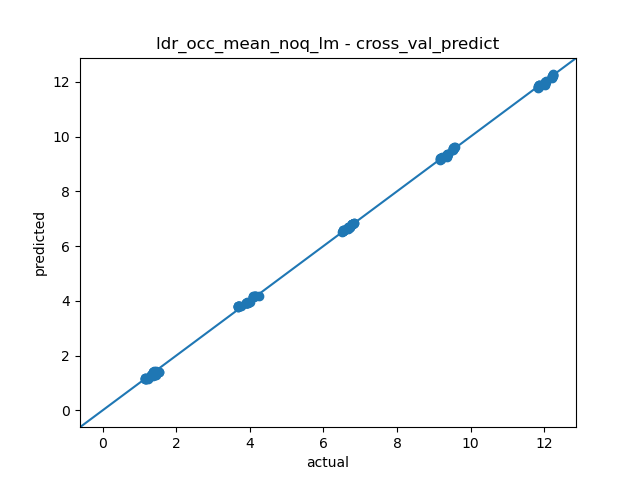

In [69]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

Linear model with noq does very well. What if we add the basicq fields? 

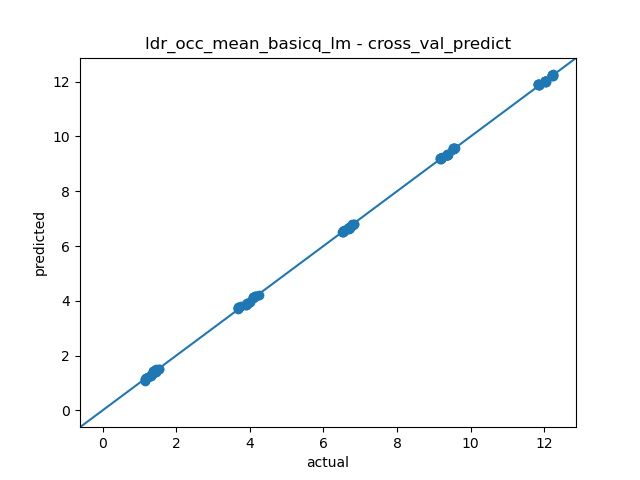

In [70]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

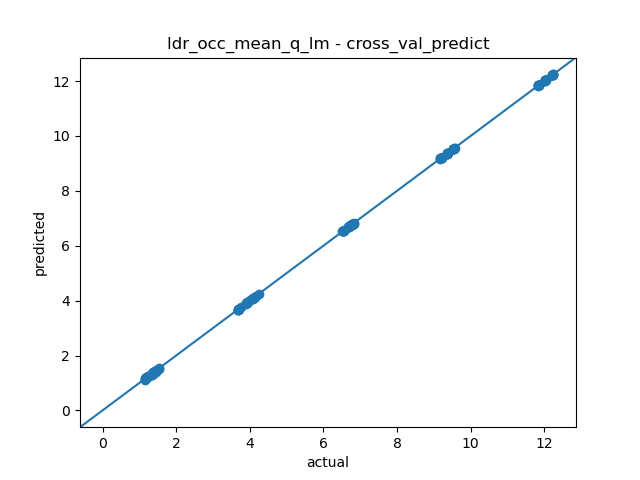

In [71]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lm_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lm_cv_coeff.png")
Image(filename=figures_path) 

Fits are great; queueing terms help. Coefficients have some instability and strange signs.

Let's look at the lasso models with q'ng.

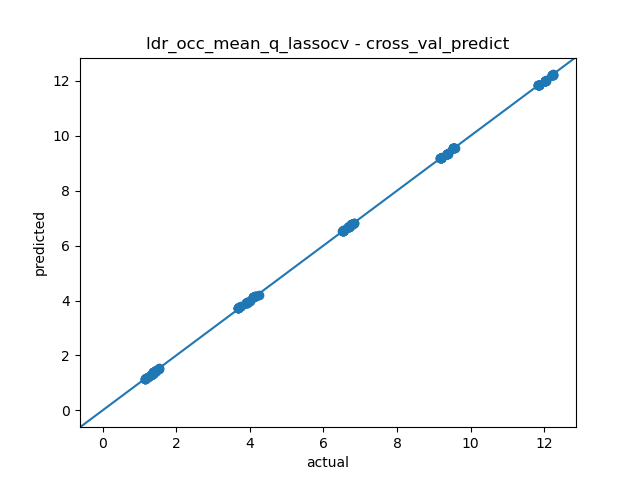

In [72]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lassocv_cv_scatter.png")
Image(filename=figures_path) 

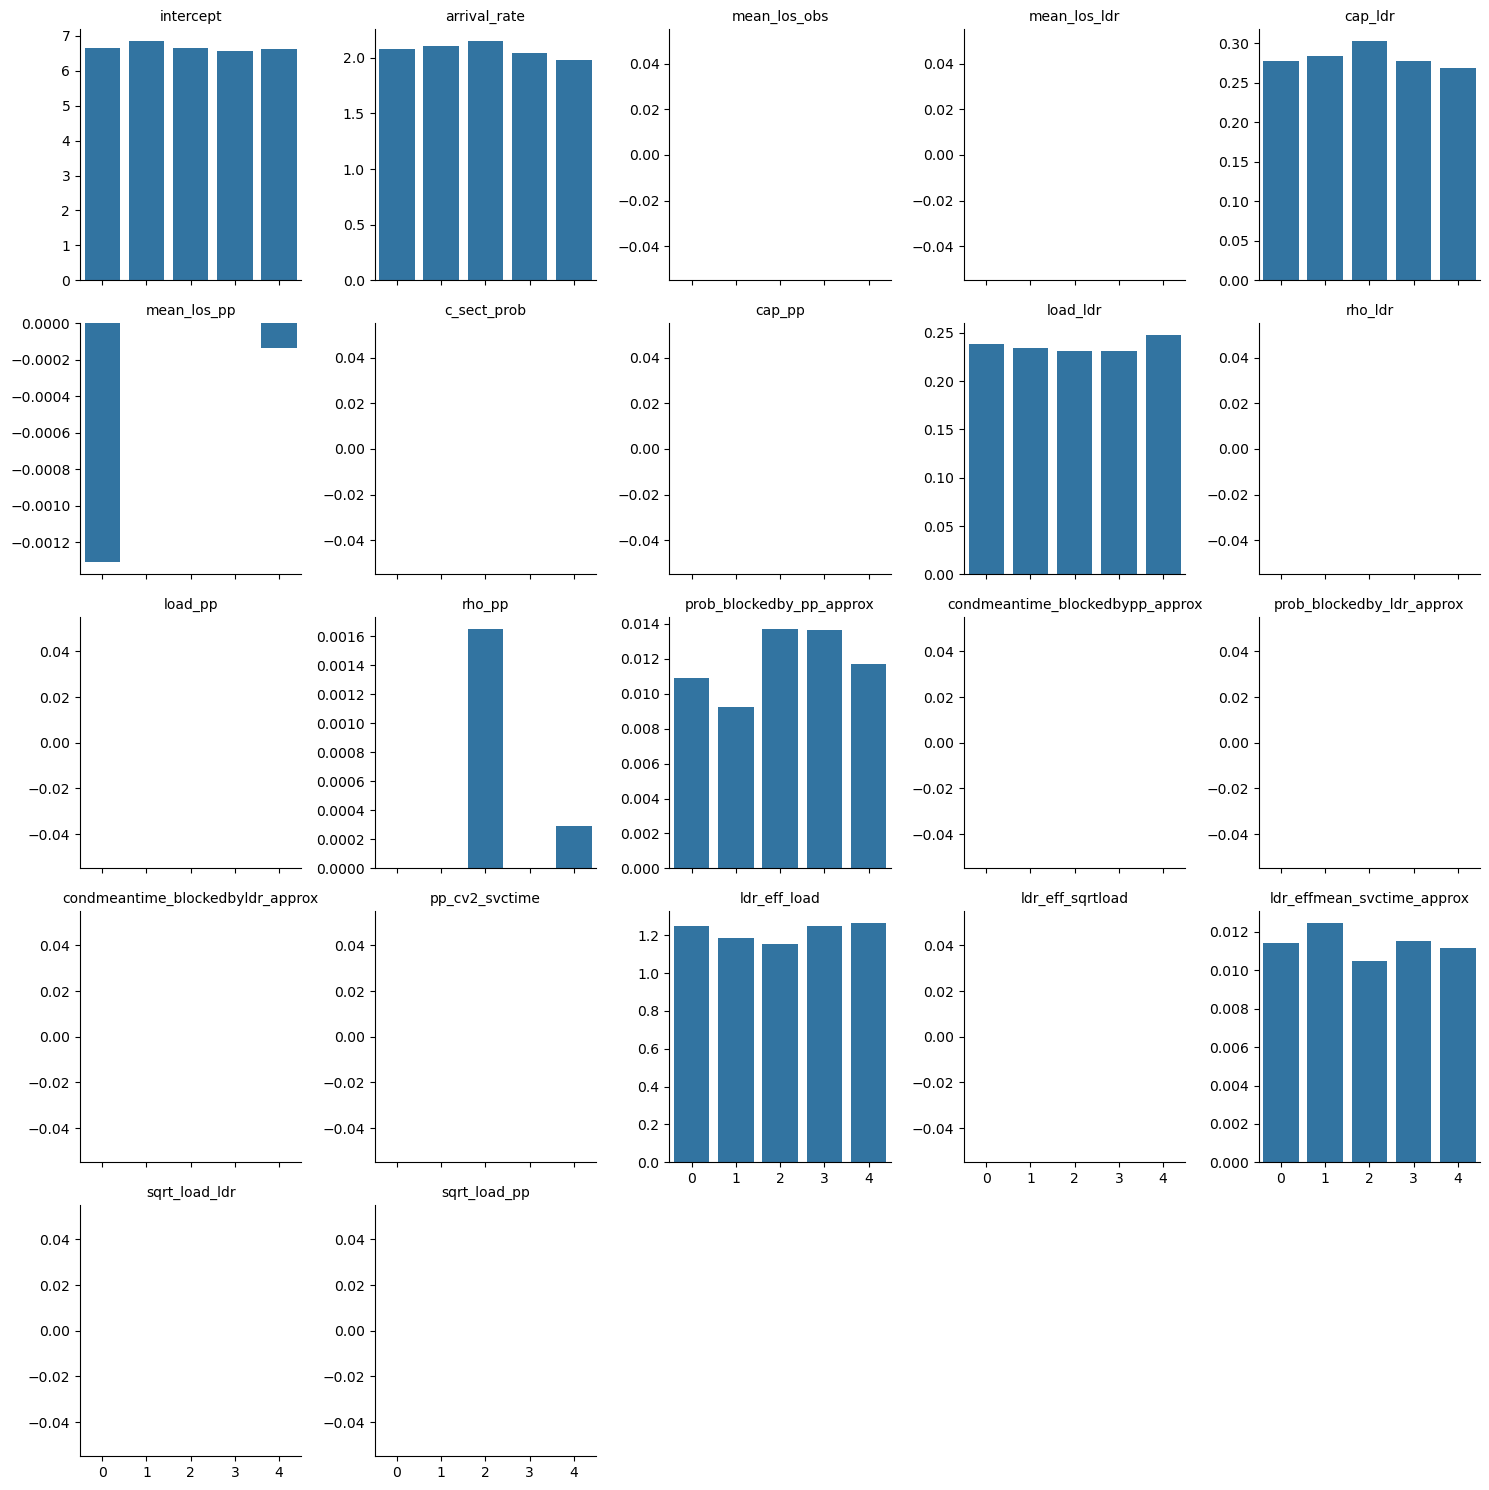

In [73]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lassocv_cv_coeff.png")
Image(filename=figures_path) 

Effective load, effective service time, prob of being blocked and associated cond mean time blocked are also showing up with positive coefficients. Make sense.
some difficult to interpret coefficient signs.

#### poly

Widely used, so let's see how it did.

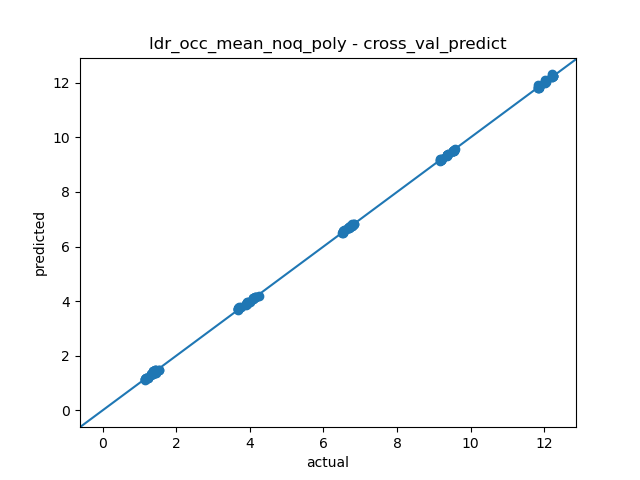

In [74]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_noq_poly_cv_scatter.png")
Image(filename=figures_path) 

The poly model fits very well even with no qng terms.

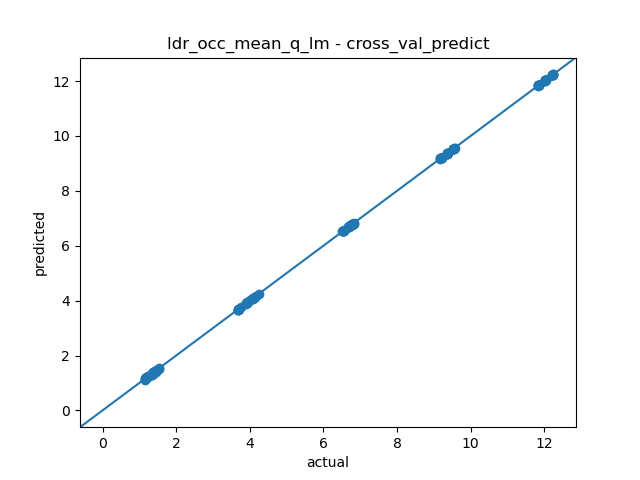

In [75]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lm_cv_scatter.png")
Image(filename=figures_path) 

What about the coeffs?

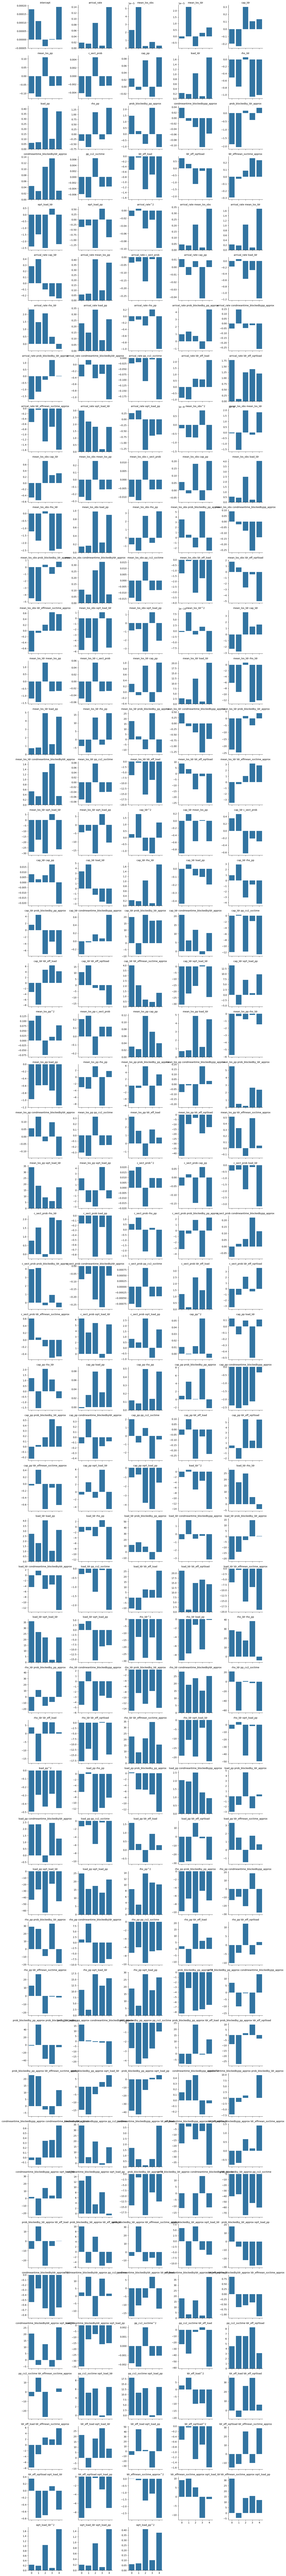

In [76]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_poly_cv_coeff.png")
Image(filename=figures_path) 

A jillion coefficients. Some strange signs and instability.

#### The ML models - rf, nn, svr

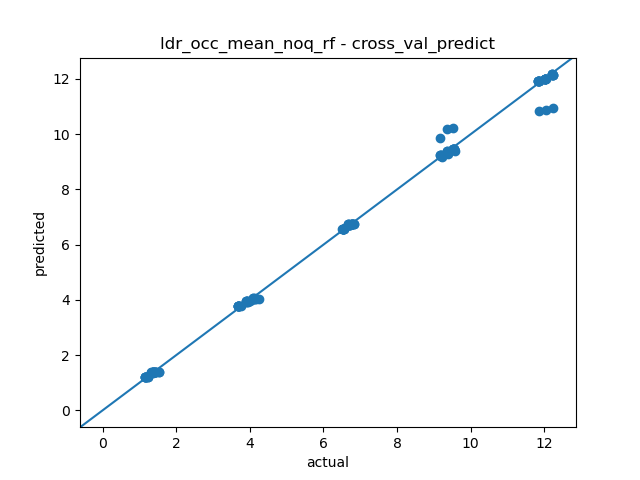

In [77]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_noq_rf_cv_scatter.png")
Image(filename=figures_path) 

Not as good as the linear models, especially at upper end of occupancy levels.

Do qnq terms help? Yes, they appear to help a bit.

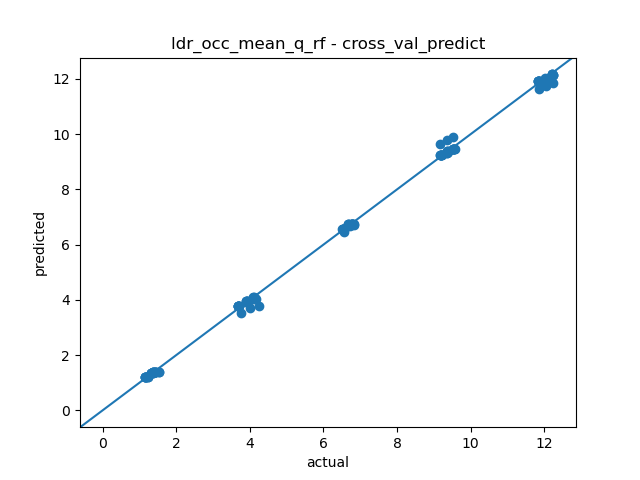

In [78]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_rf_cv_scatter.png")
Image(filename=figures_path) 

Now for the neural nets. Overall, they perform poorly and if the qng terms help, it's not much.

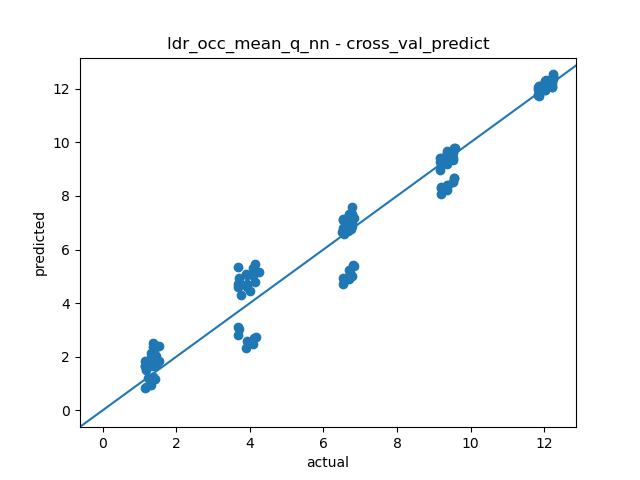

In [79]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_nn_cv_scatter.png")
Image(filename=figures_path) 

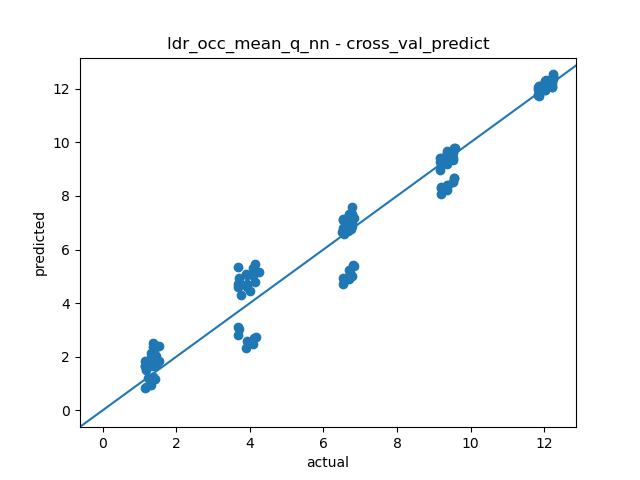

In [80]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_nn_cv_scatter.png")
Image(filename=figures_path) 

Finally, let's look at the svrs. Overall, they perform poorly and if the qng terms help, it's not much.

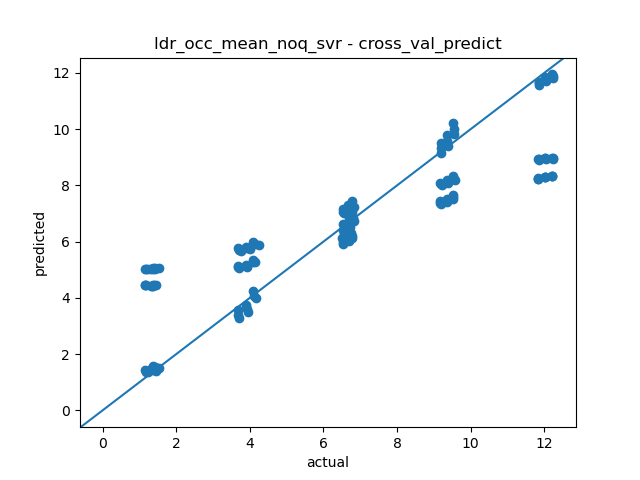

In [81]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_noq_svr_cv_scatter.png")
Image(filename=figures_path) 

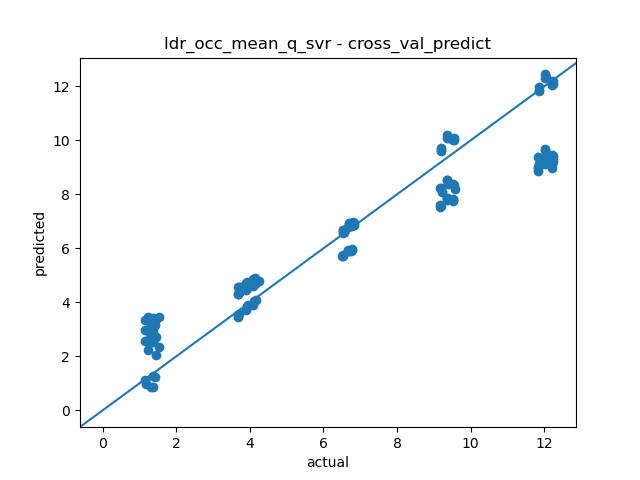

In [82]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_svr_cv_scatter.png")
Image(filename=figures_path) 

What about the queuing approximation based models?

In [85]:
ldr_results.keys()

dict_keys(['ldr_occ_mean_basicq_lm_results', 'ldr_occ_mean_q_lm_results', 'ldr_occ_mean_noq_lm_results', 'ldr_occ_mean_basicq_lassocv_results', 'ldr_occ_mean_q_lassocv_results', 'ldr_occ_mean_noq_lassocv_results', 'ldr_occ_mean_basicq_poly_results', 'ldr_occ_mean_q_poly_results', 'ldr_occ_mean_noq_poly_results', 'ldr_occ_mean_basicq_rf_results', 'ldr_occ_mean_q_rf_results', 'ldr_occ_mean_noq_rf_results', 'ldr_occ_mean_basicq_svr_results', 'ldr_occ_mean_q_svr_results', 'ldr_occ_mean_noq_svr_results', 'ldr_occ_mean_basicq_nn_results', 'ldr_occ_mean_q_nn_results', 'ldr_occ_mean_noq_nn_results', 'ldr_occ_mean_q_load_results', 'ldr_occ_p95_basicq_lm_results', 'ldr_occ_p95_q_lm_results', 'ldr_occ_p95_noq_lm_results', 'ldr_occ_p95_basicq_lassocv_results', 'ldr_occ_p95_q_lassocv_results', 'ldr_occ_p95_noq_lassocv_results', 'ldr_occ_p95_basicq_poly_results', 'ldr_occ_p95_q_poly_results', 'ldr_occ_p95_noq_poly_results', 'ldr_occ_p95_basicq_rf_results', 'ldr_occ_p95_q_rf_results', 'ldr_occ_p95_no

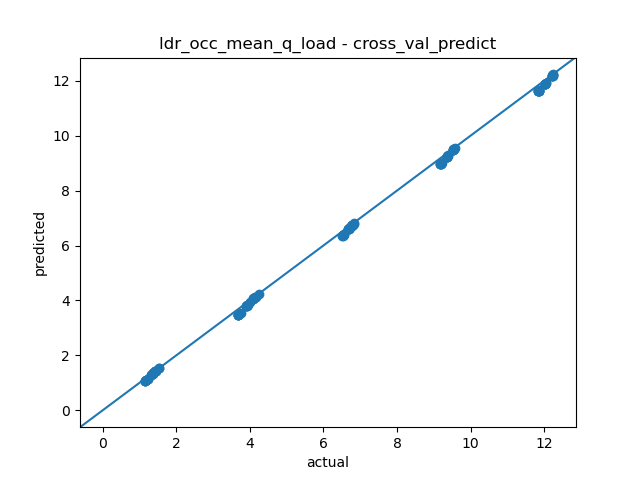

In [90]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_load_cv_scatter.png")
Image(filename=figures_path) 

Effective load alone performs extremely well.

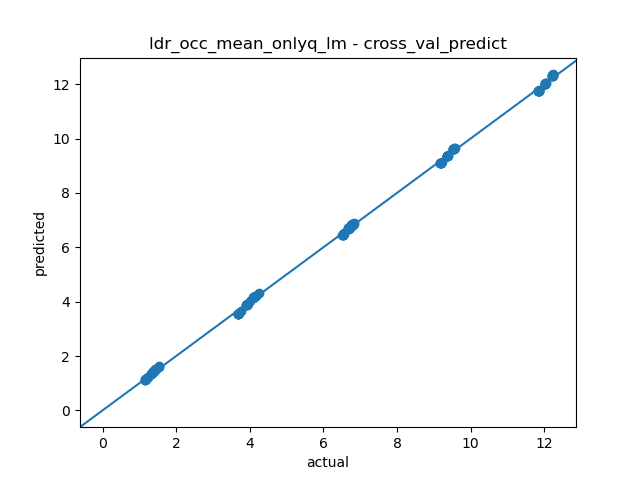

In [87]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_onlyq_lm_cv_scatter.png")
Image(filename=figures_path) 

In [88]:
ldr_results['ldr_occ_mean_onlyq_lm_results']['coeffs_df']

intercept  ldr_eff_load
0   0.059946      1.006097
1   0.051957      1.006749
2   0.051045      1.006641
3   0.059722      1.005457
4   0.056793      1.005965

In [91]:
ldr_results['ldr_occ_mean_onlyq_lm_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.064717                   0.056652   
1                  0.068554                   0.055344   
2                  0.051898                   0.059365   
3                  0.051151                   0.060075   
4                  0.055418                   0.058711   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.016212                              0.013596   
1                             0.017602                              0.013013   
2                             0.012147                              0.014331   
3                             0.012254                              0.014551   
4                             0.012499                              0.014400   

    test_r2  train_r2  
0  0.999628  0.999682  
1  0.999566  0.999694  
2  0.999664  0.999674  
3  0.999728  0.999657  
4  0.999725  0.999657

In [92]:
ldr_results['ldr_occ_mean_noq_poly_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.019608                   0.016550   
1                  0.020509                   0.015639   
2                  0.017995                   0.016637   
3                  0.018267                   0.017480   
4                  0.020178                   0.016320   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.007503                              0.005750   
1                             0.007502                              0.005494   
2                             0.004696                              0.006057   
3                             0.007250                              0.005825   
4                             0.005882                              0.006007   

    test_r2  train_r2  
0  0.999950  0.999968  
1  0.999955  0.999967  
2  0.999954  0.999967  
3  0.999957  0.999966  
4  0.999951  0.999967

In [93]:
ldr_results['ldr_occ_mean_noq_poly_results']['coeffs_df']

intercept  arrival_rate  mean_los_obs  mean_los_ldr   cap_ldr  \
0 -3.574004e-10      0.109352  9.436632e-11  4.530747e-11  0.001224   
1 -3.604860e-10      0.100947 -7.876391e-11 -3.628722e-11  0.001870   
2 -2.444432e-10      0.076720 -5.530274e-10 -1.943578e-10  0.002015   
3 -2.521624e-10      0.105047  1.899666e-10  6.243540e-12  0.002364   
4 -3.866790e-11      0.043973  3.782131e-11  8.324125e-12  0.002456   

   mean_los_pp  c_sect_prob    cap_pp  arrival_rate^2  \
0     0.006206     0.000259 -0.000747       -8.118972   
1     0.005164     0.000215 -0.000726       -7.114540   
2     0.007632     0.000318 -0.000442       -6.545290   
3     0.010017     0.000417 -0.000932       -7.701022   
4     0.004138     0.000172 -0.000115       -5.471593   

   arrival_rate mean_los_obs  ...  cap_ldr^2  cap_ldr mean_los_pp  \
0                   0.262445  ...  -0.032879             0.000867   
1                   0.242272  ...  -0.033860            -0.000840   
2                   0.184129  ...  -0.032582            -0.001461   
3                   0.252112  ...  -0.034525            -0.002136   
4                   0.105535  ...  -0.032959            -0.002470   

   cap_ldr c_sect_prob  cap_ldr cap_pp  mean_los_pp^2  \
0            -0.002412       -0.000579      -0.008452   
1            -0.003775       -0.000048      -0.006977   
2            -0.004091        0.000038      -0.010288   
3            -0.004817       -0.000092      -0.013575   
4            -0.005015       -0.000795      -0.005590   

   mean_los_pp c_sect_prob  mean_los_pp cap_pp  c_sect_prob^2  \
0                -0.012765            0.001676      -0.001049   
1                -0.010618            0.001612      -0.000873   
2                -0.015693            0.000800      -0.001290   
3                -0.020600            0.002199      -0.001693   
4                -0.008509           -0.000118      -0.000699   

   c_sect_prob cap_pp  cap_pp^2  
0            0.001563  0.000148  
1            0.001520  0.000260  
2            0.000918  0.000318  
3            0.001956  0.000154  
4            0.000226  0.000677  

[5 rows x 36 columns]

Poly fits well but with 36 variables. What about lasso with q.

In [94]:
ldr_results['ldr_occ_mean_q_lassocv_results']['metrics_df']

test_mean_absolute_error  train_mean_absolute_error  \
0                  0.014474                   0.016439   
1                  0.020436                   0.016951   
2                  0.021652                   0.015814   
3                  0.015367                   0.015636   
4                  0.012855                   0.016360   

   test_mean_absolute_percentage_error  train_mean_absolute_percentage_error  \
0                             0.004412                              0.004947   
1                             0.006897                              0.004920   
2                             0.005515                              0.004766   
3                             0.004147                              0.004769   
4                             0.004311                              0.004840   

    test_r2  train_r2  
0  0.999974  0.999971  
1  0.999948  0.999970  
2  0.999948  0.999971  
3  0.999978  0.999971  
4  0.999982  0.999970

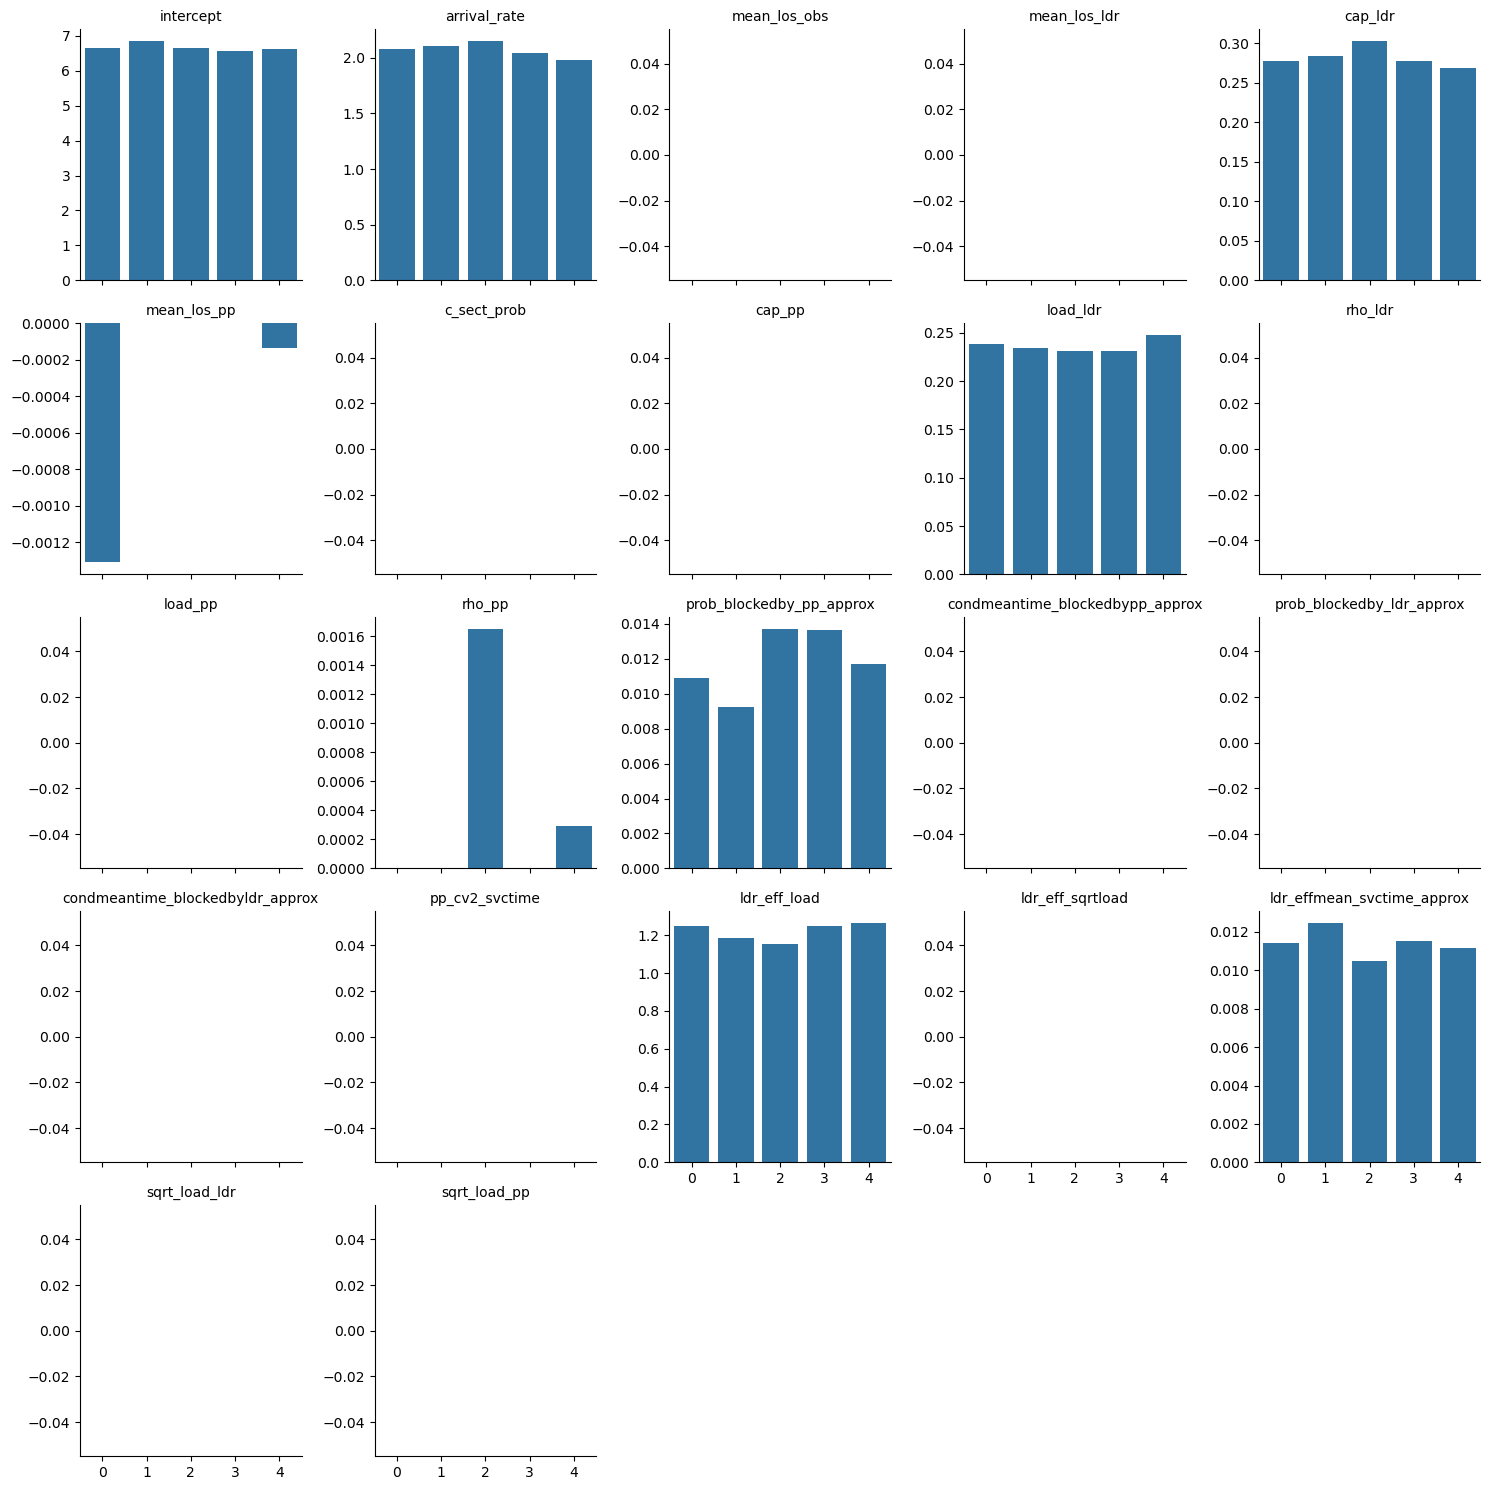

In [97]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lassocv_cv_coeff.png")
Image(filename=figures_path) 

Lasso with q terms performs as well as poly noq but with way fewer variables.

### LDR 95%ile occupancy

#### lm and lassocv

Let's start here as they are simplest.

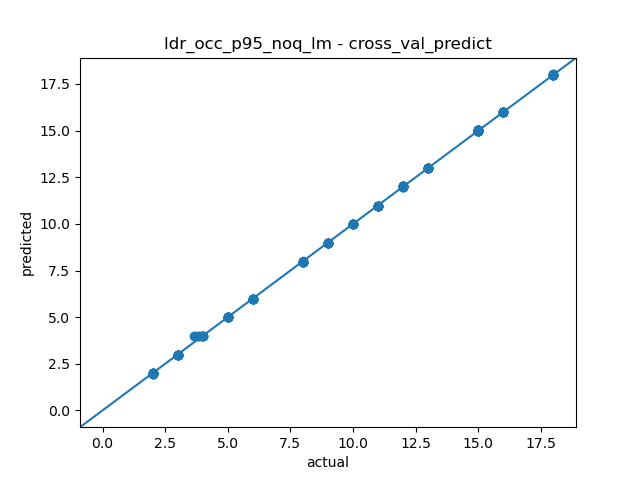

In [98]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

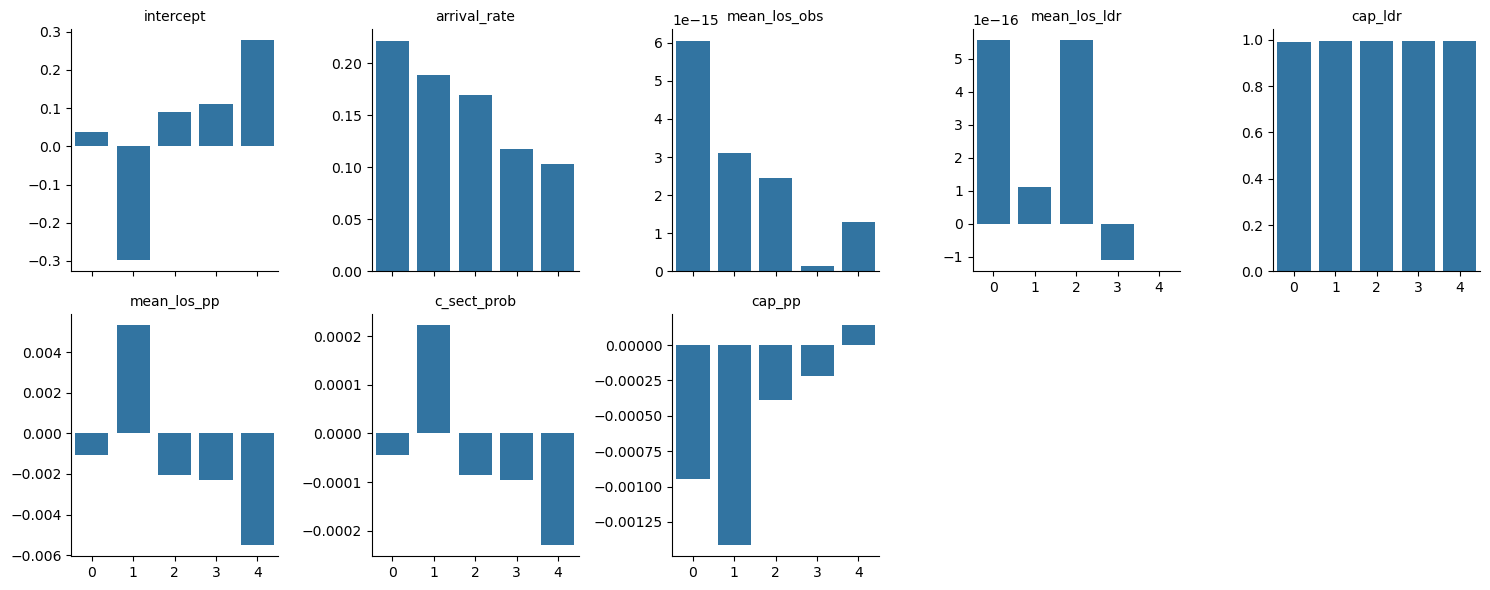

In [99]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_noq_lm_cv_coeff.png")
Image(filename=figures_path) 

The above coeffs are a bit baffling and surprising it fits so well - aaahhh, it's a pretty packed unit and the 95th percentile is usually the capacity. Seems like all modeling techniques should work well.

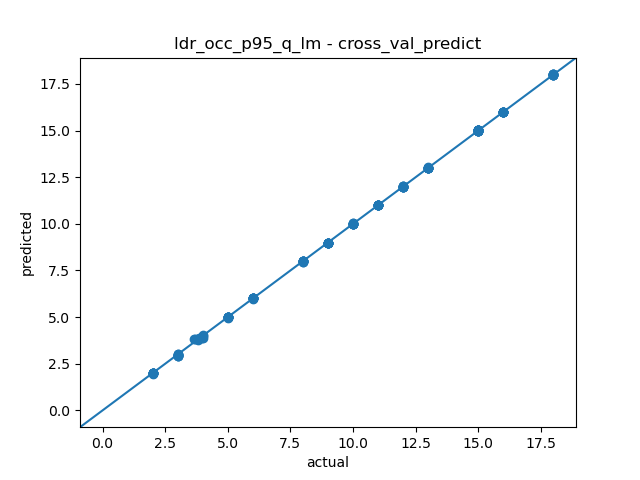

In [100]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_lm_cv_scatter.png")
Image(filename=figures_path) 

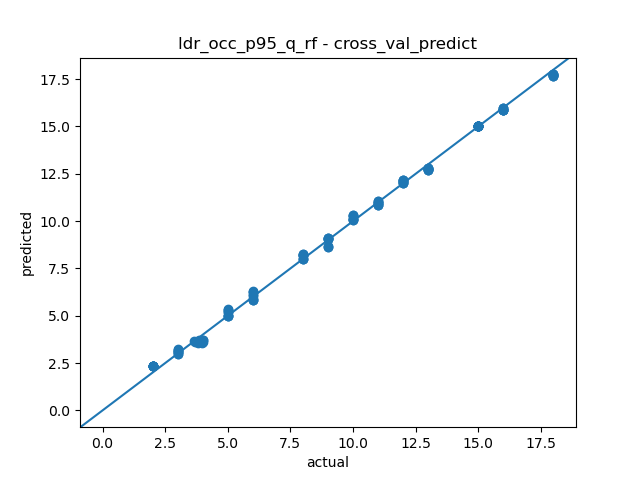

In [101]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_rf_cv_scatter.png")
Image(filename=figures_path) 

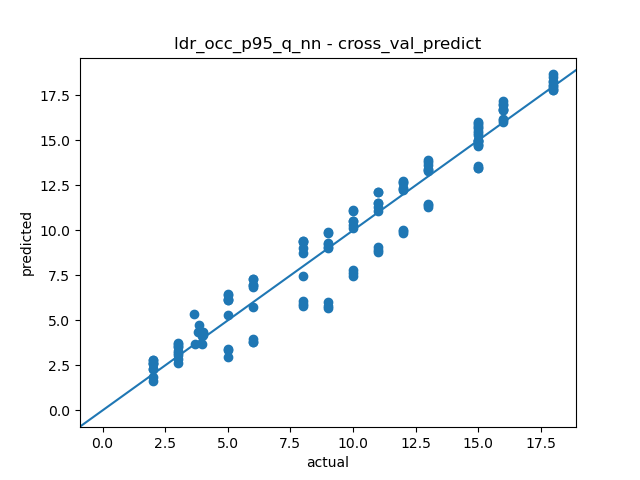

In [102]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_nn_cv_scatter.png")
Image(filename=figures_path) 

The NN is still pretty bad

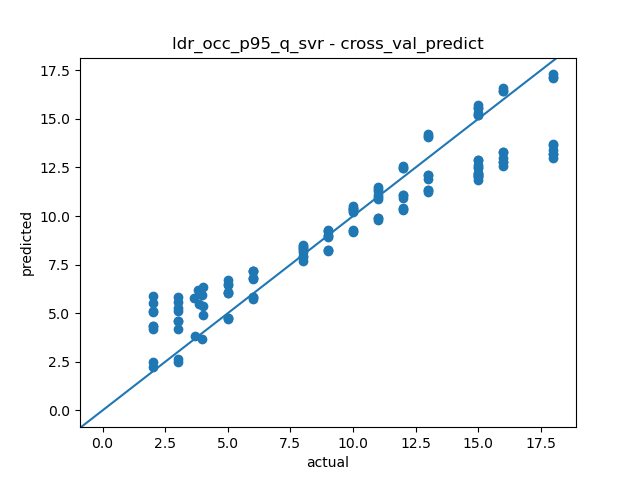

In [103]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_svr_cv_scatter.png")
Image(filename=figures_path) 

... as is the SVM

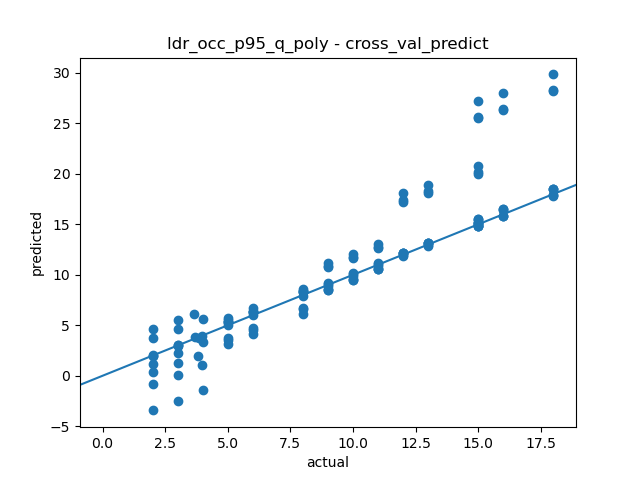

In [104]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_poly_cv_scatter.png")
Image(filename=figures_path) 

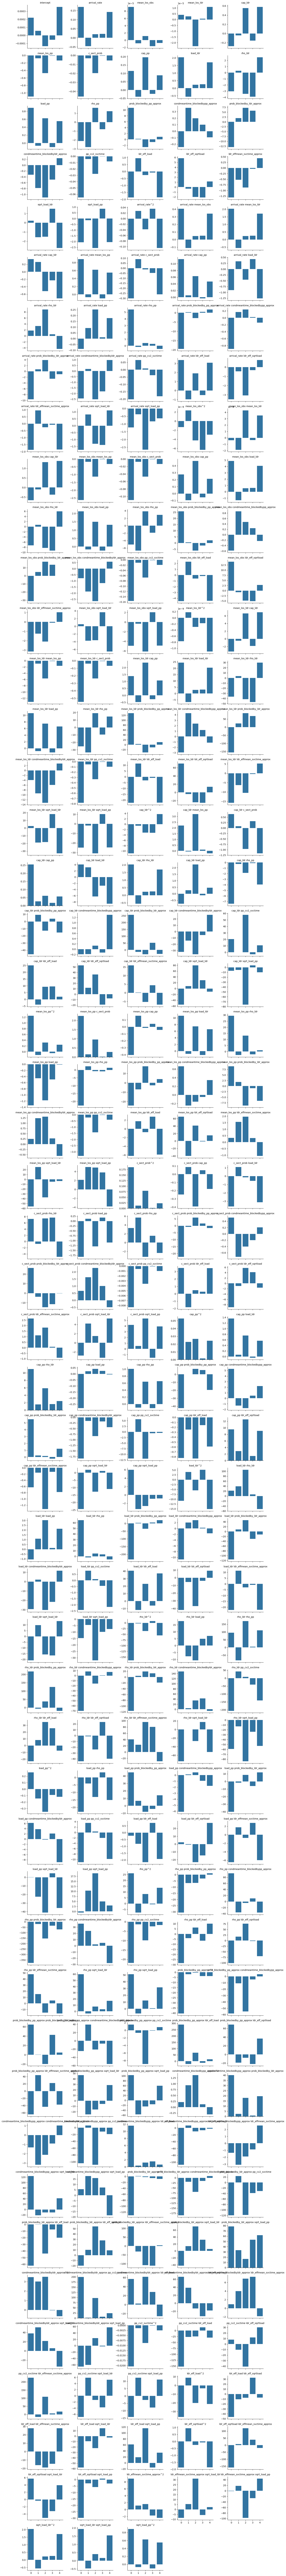

In [107]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_poly_cv_coeff.png")
Image(filename=figures_path) 

WTF? Is this truly from overfitting?

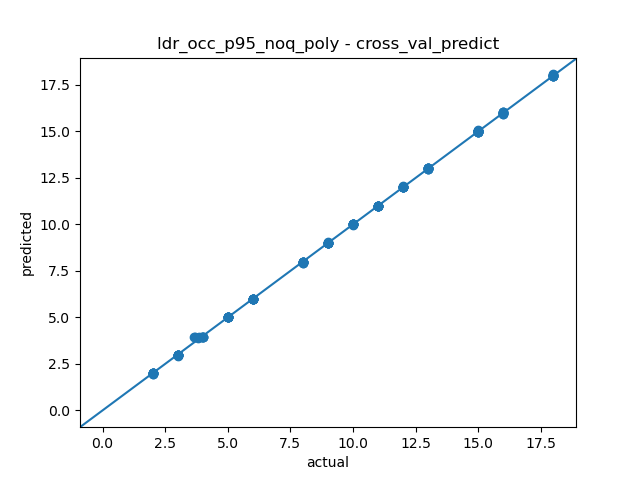

In [105]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_noq_poly_cv_scatter.png")
Image(filename=figures_path) 

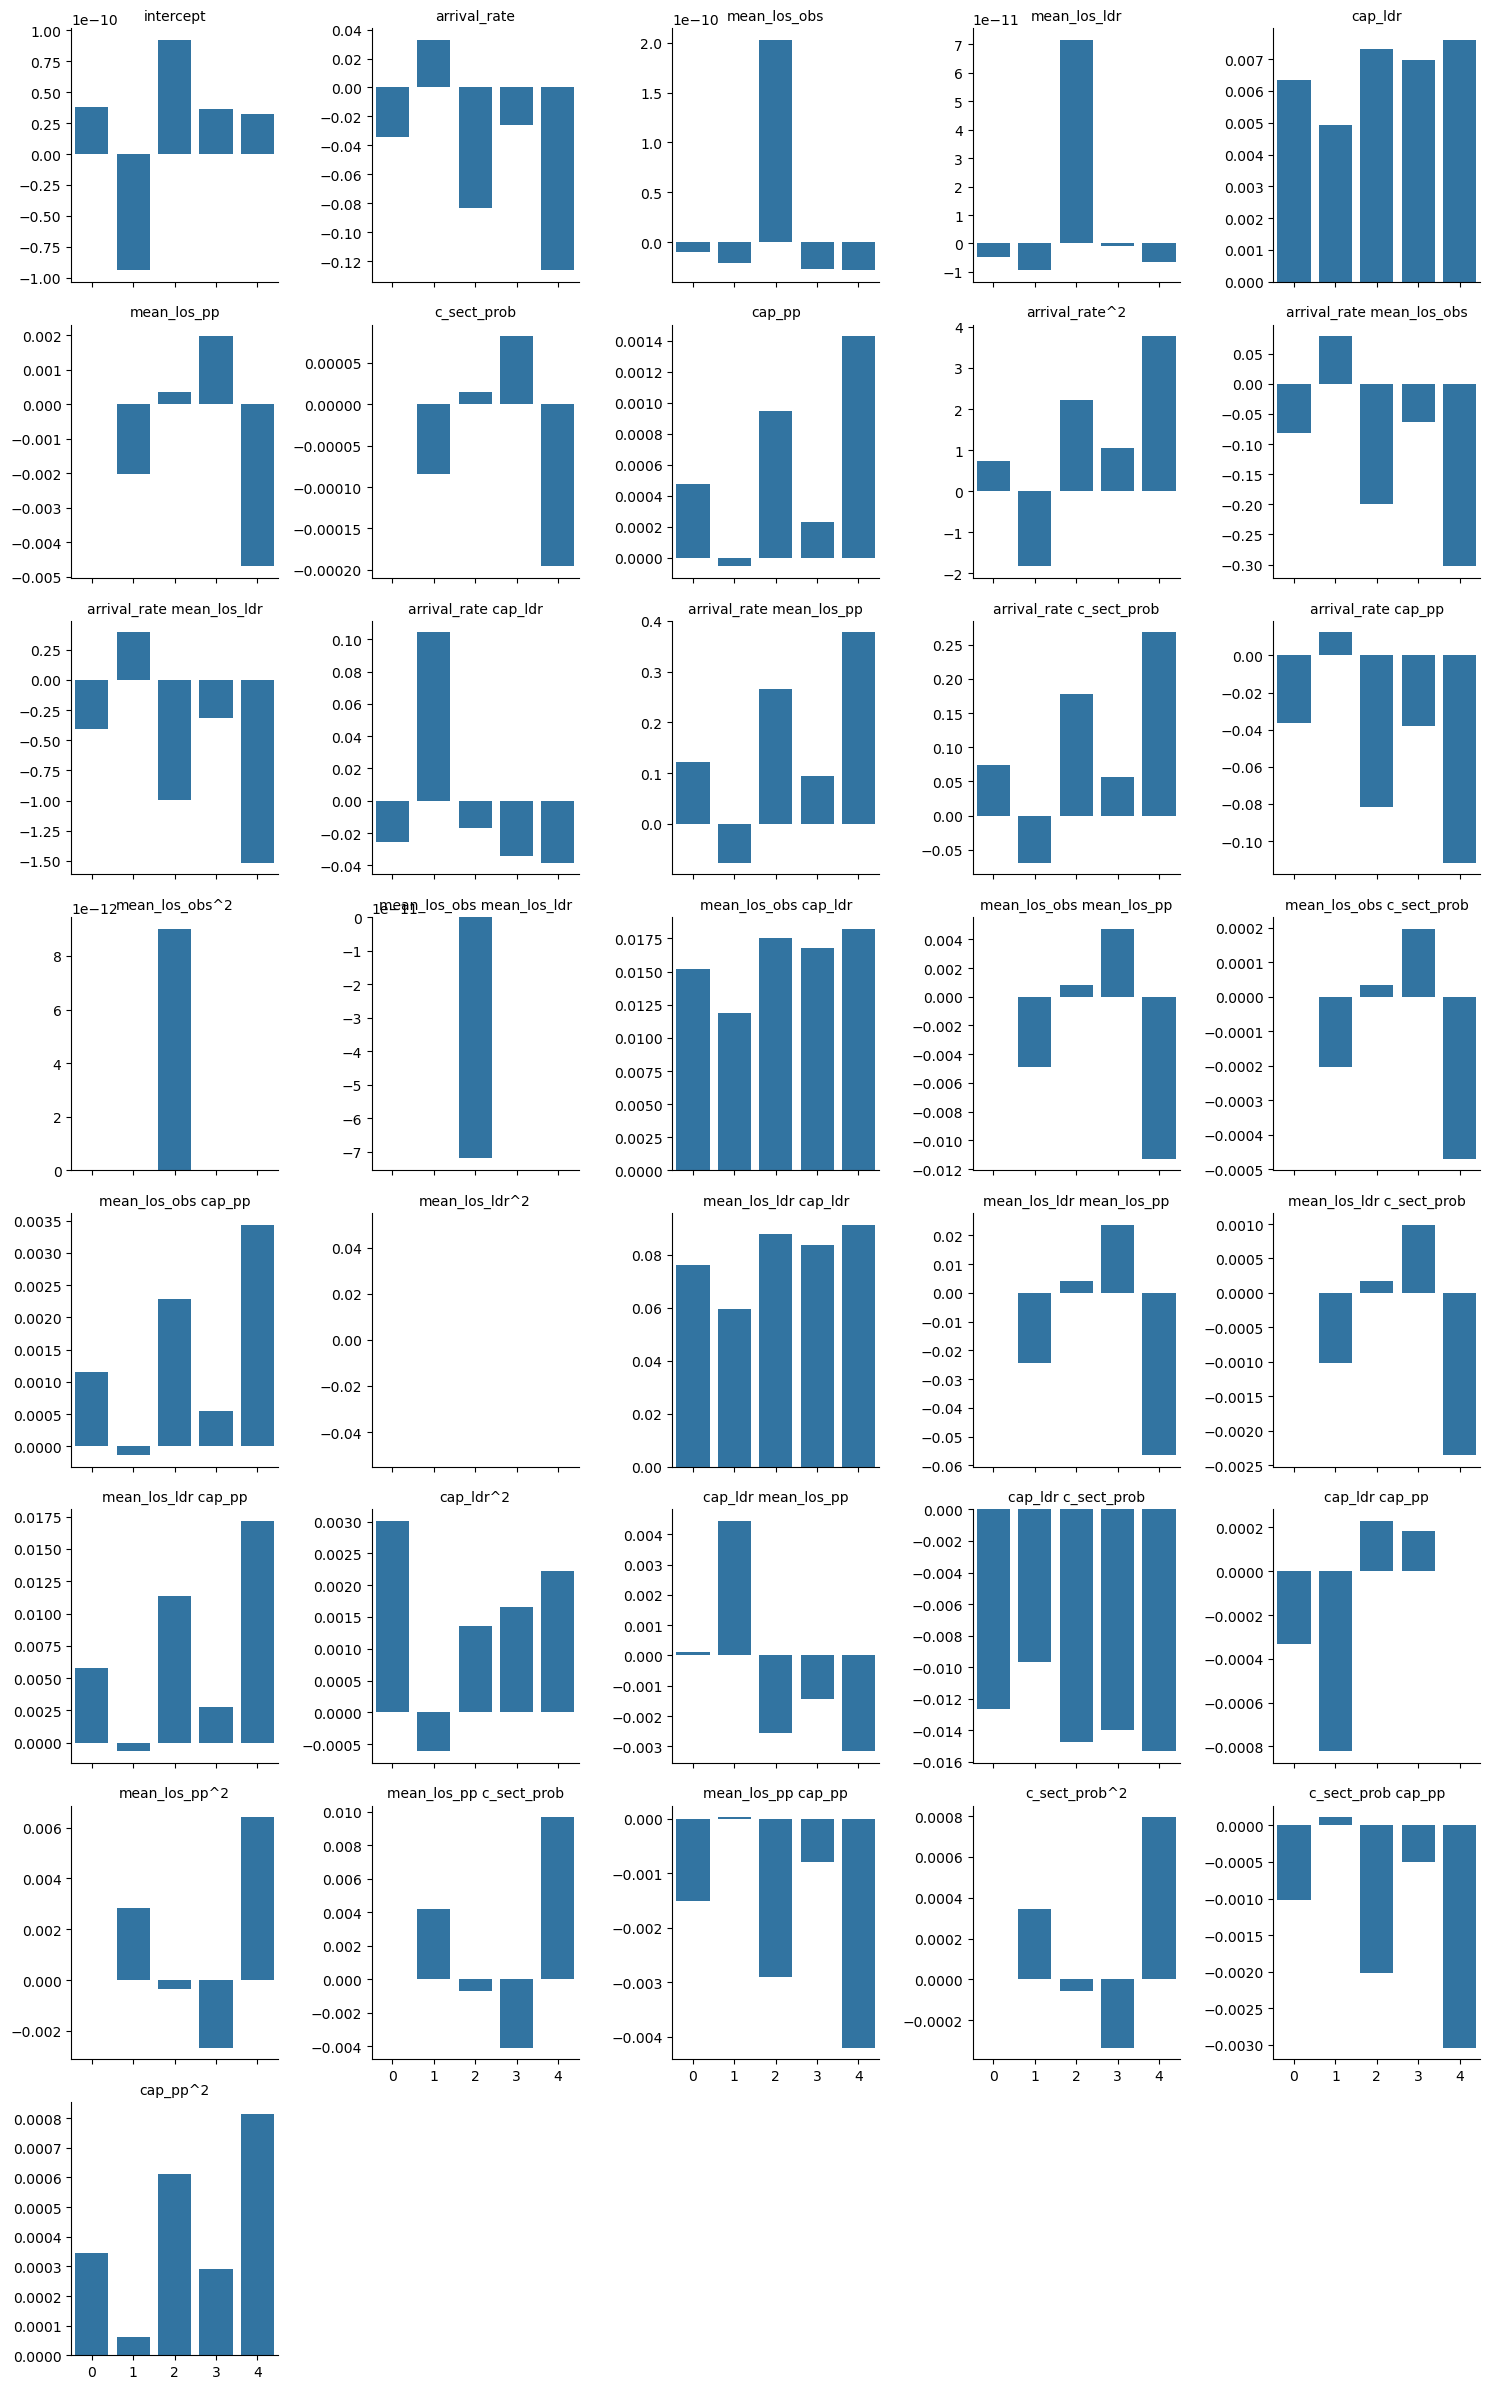

In [106]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_noq_poly_cv_coeff.png")
Image(filename=figures_path) 

### LDR pct blocked

Welp, looking at the plots below, for some reason I didn't include erlangc terms in these models. Seems like they should have been in all the q based X dataframes. Wait, they are. Why doesn't the coeff plot below include them. Strangely, the erlangc vars are in the basicq plots.

**RESOLUTION - 2021-09-13** Yes, in `run_mm_fits_ldr.py` I literally flipped the scenario names for basicq and q for pct blocked for all the model types. Eventually will need to rerun everything anyway because I'm sure there are additional issues to be fixed. All models have been rerun as of 2021-09-22.

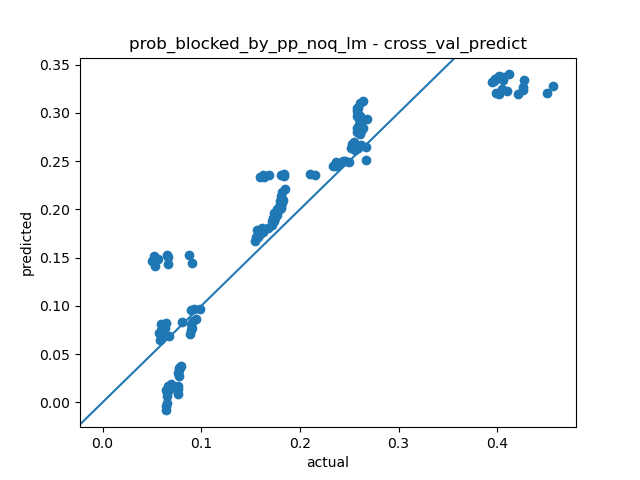

In [109]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blocked_by_pp_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

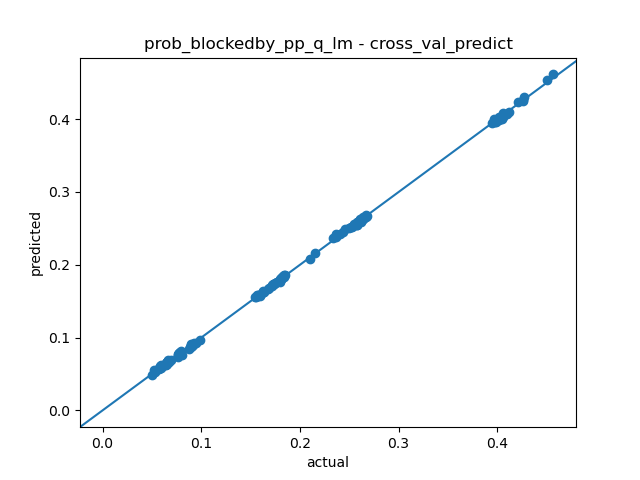

In [135]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blockedby_pp_q_lm_cv_scatter.png")
Image(filename=figures_path) 

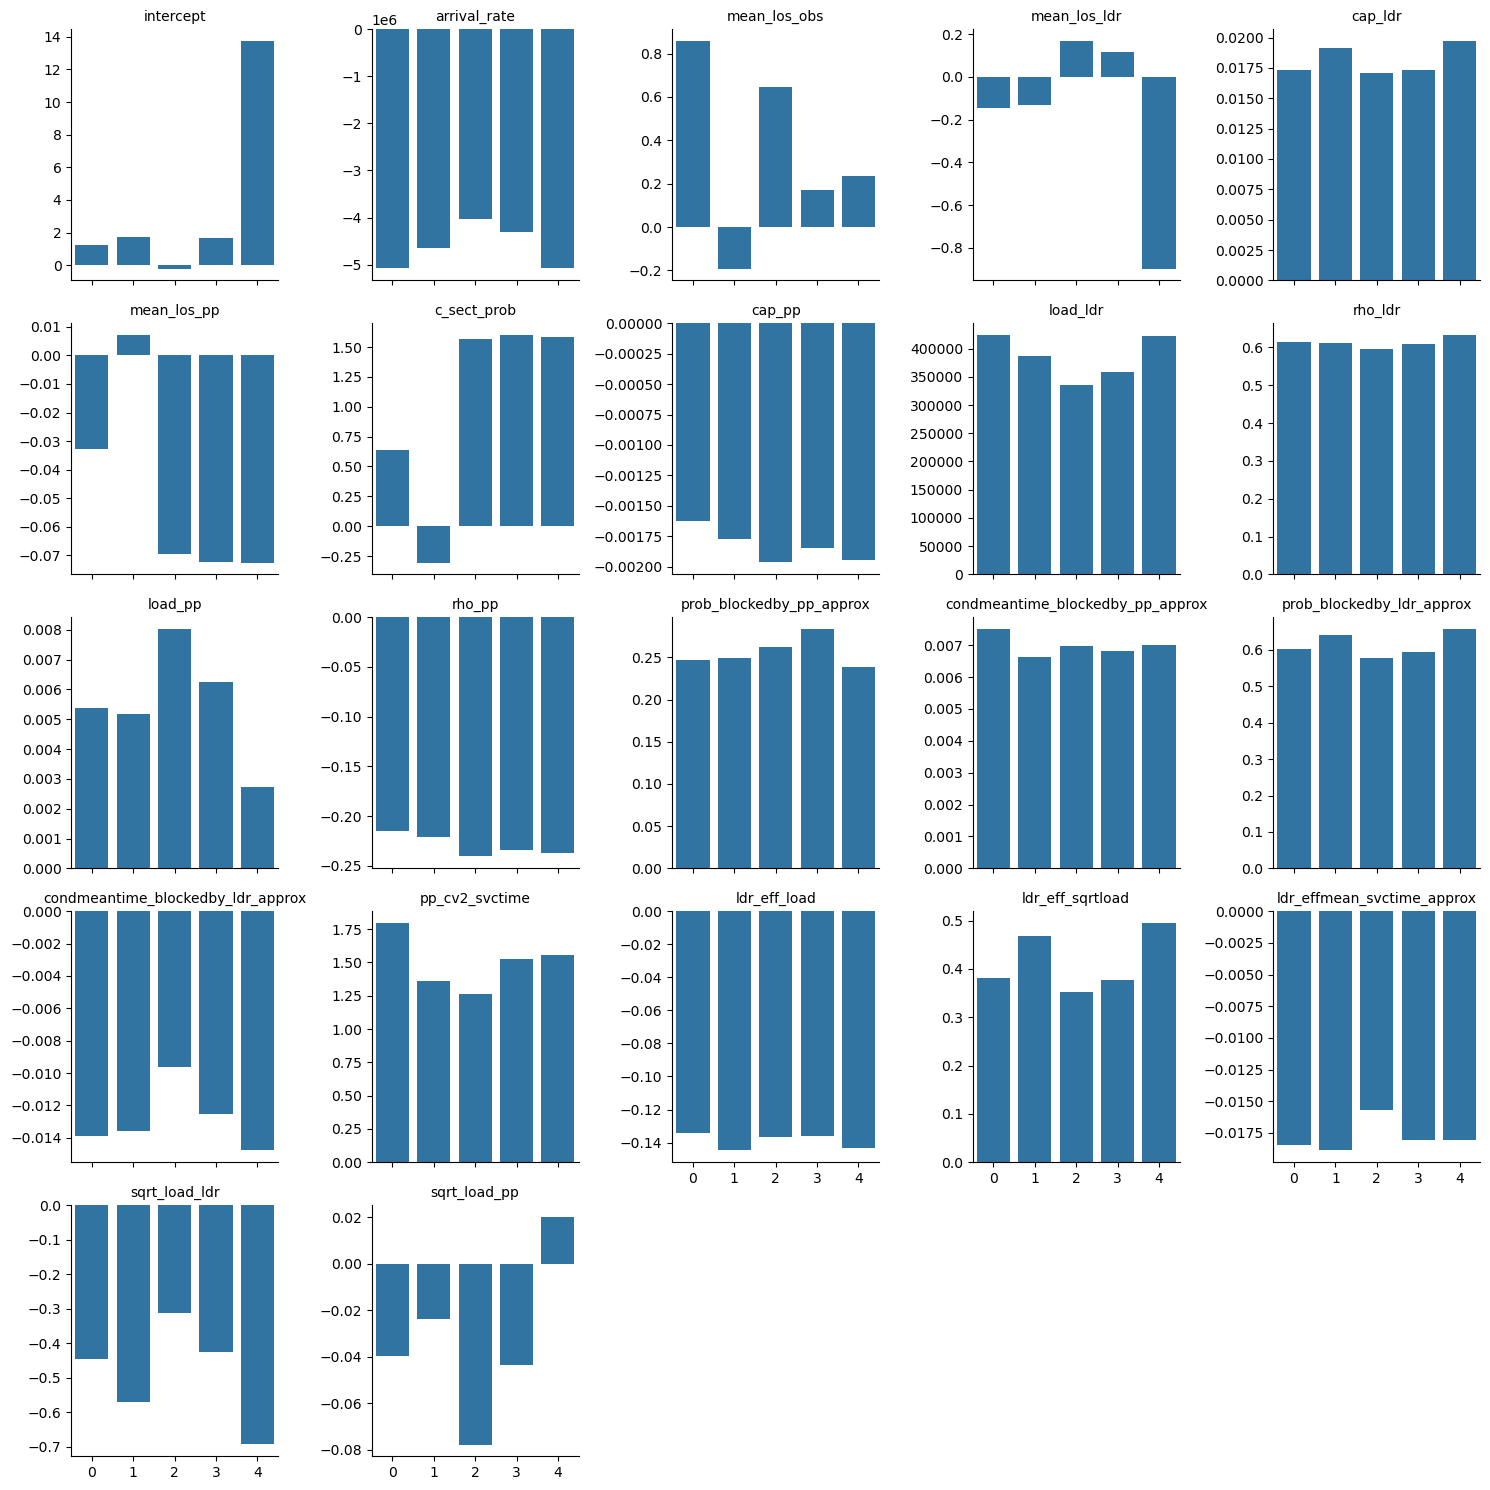

In [137]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blockedby_pp_q_lm_cv_coeff.png")
Image(filename=figures_path) 

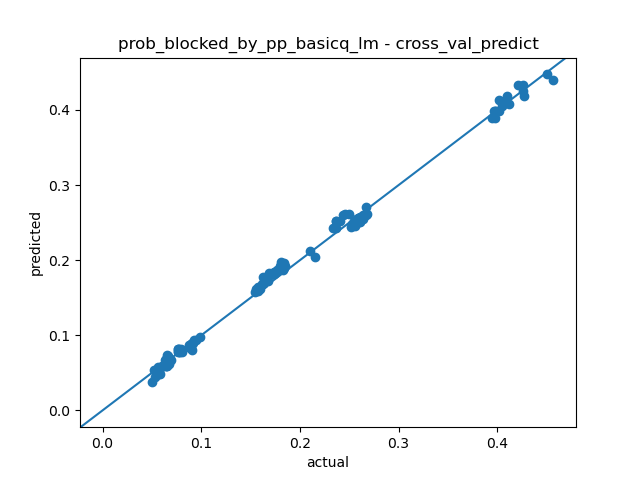

In [113]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blocked_by_pp_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

Clearly the queuing terms make an enormous impact on performance.

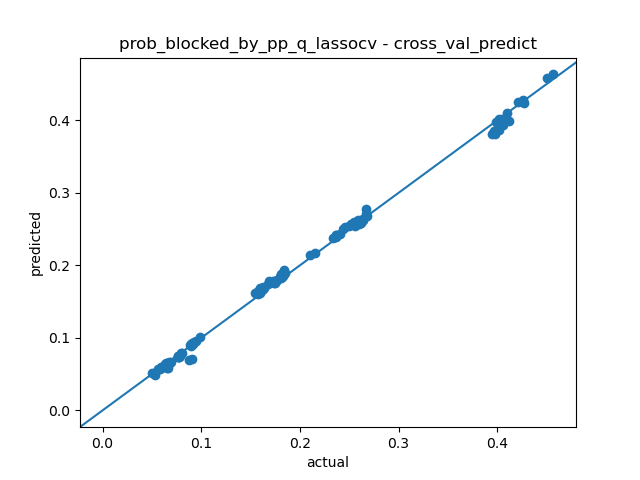

In [114]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blocked_by_pp_q_lassocv_cv_scatter.png")
Image(filename=figures_path) 

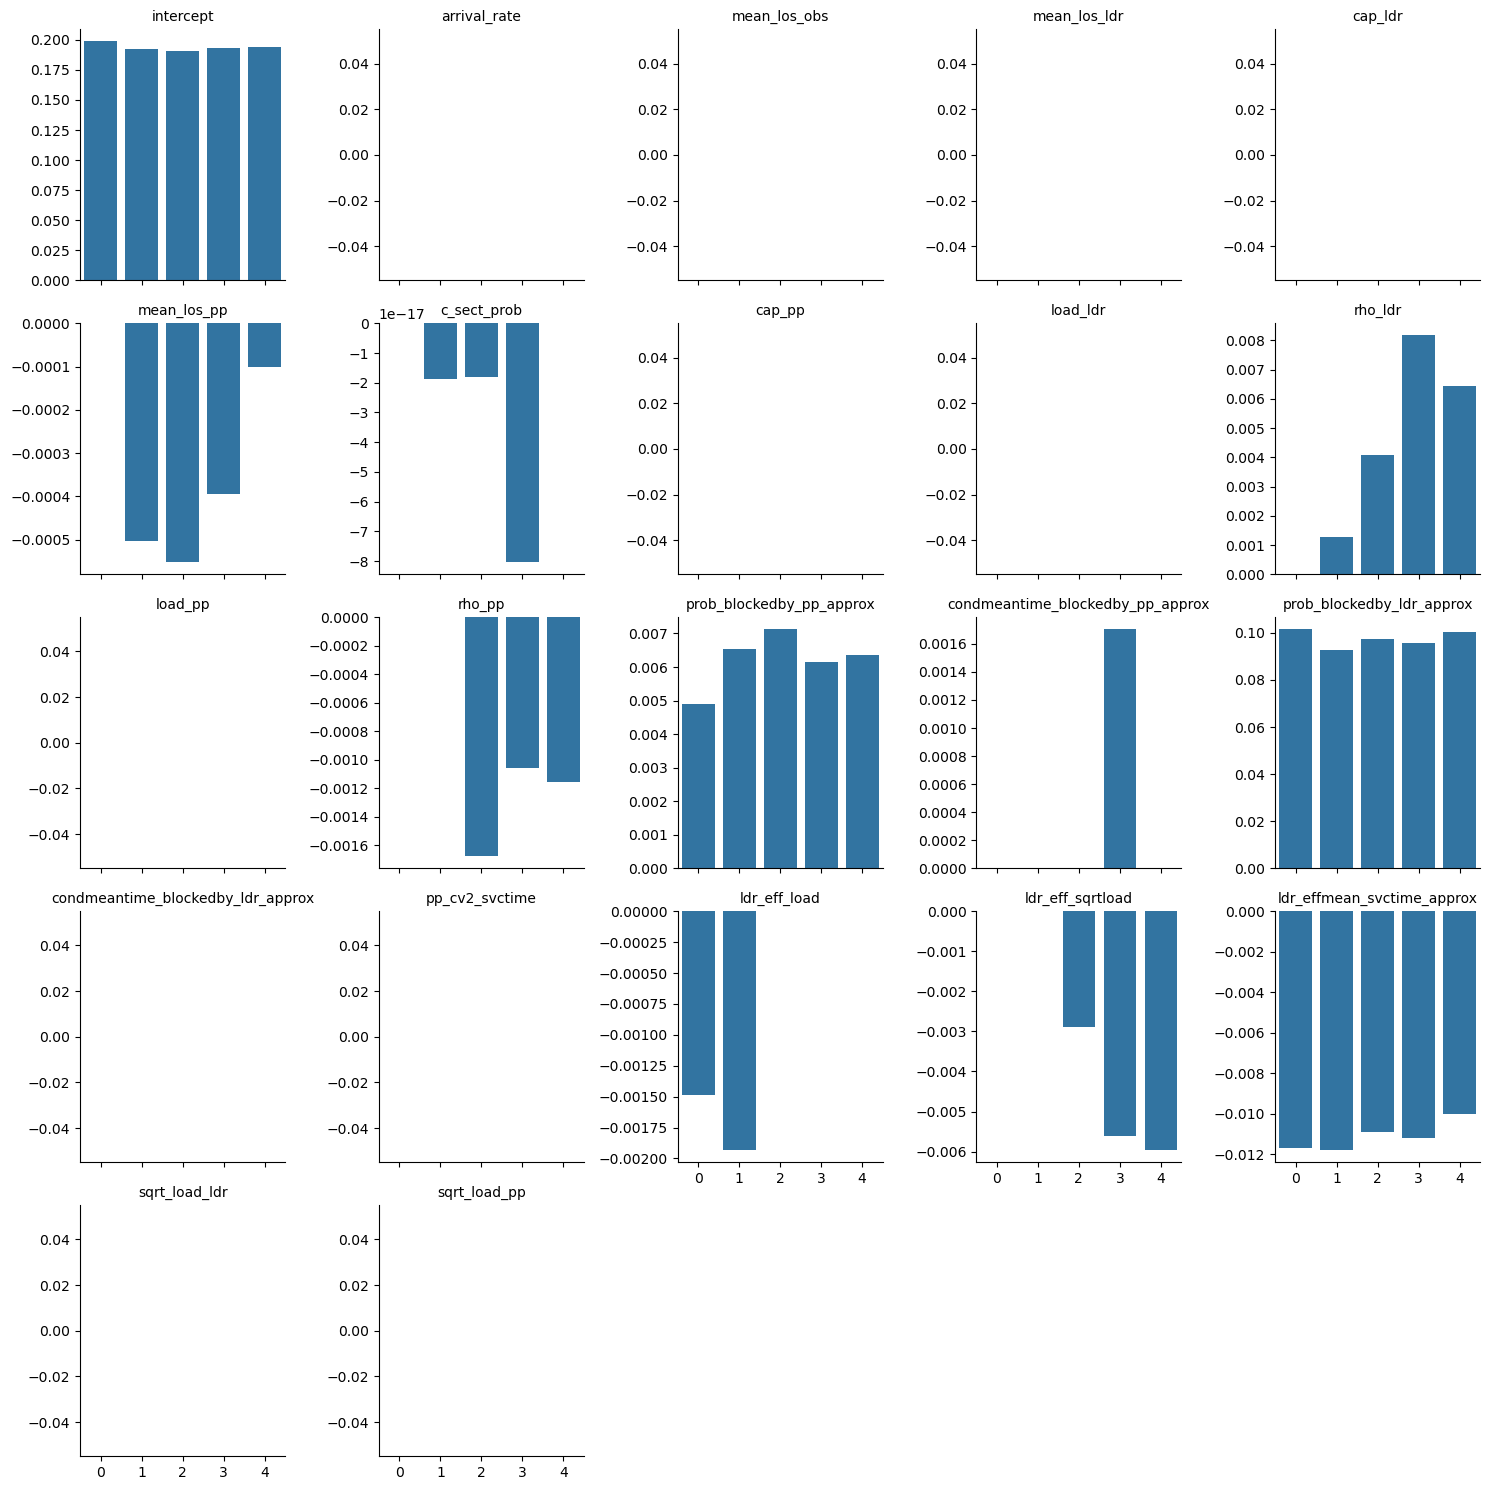

In [124]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blockedby_pp_q_lassocv_cv_coeff.png")
Image(filename=figures_path) 

Hard to make sense of the coeffs above.

Let's try the qng approx's.

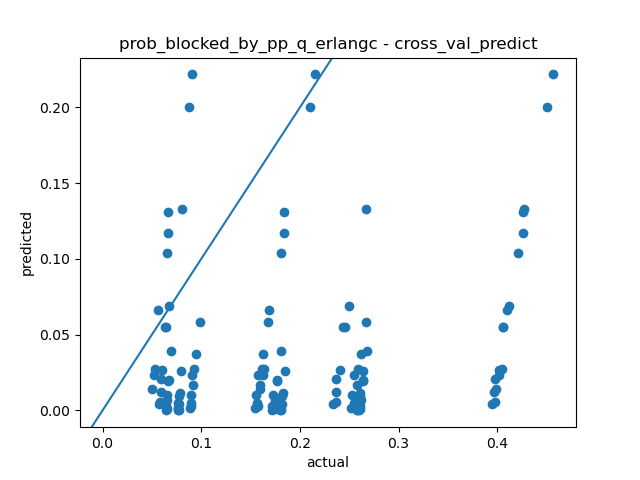

In [116]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blocked_by_pp_q_erlangc_cv_scatter.png")
Image(filename=figures_path) 

Yikes! What the heck did I use in the erlangc approx for service time and num servers? They should be the overall mean service time in PP and capacity of PP. Yep, I used the correct columns. What a terrible approximation when used by itself.

... and it's still terrible when used by itself in an lm. Not surprising at all.

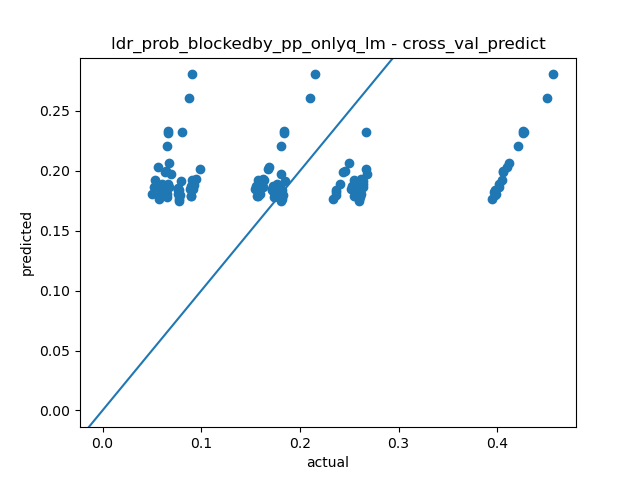

In [121]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_prob_blockedby_pp_onlyq_lm_cv_scatter.png")
Image(filename=figures_path) 

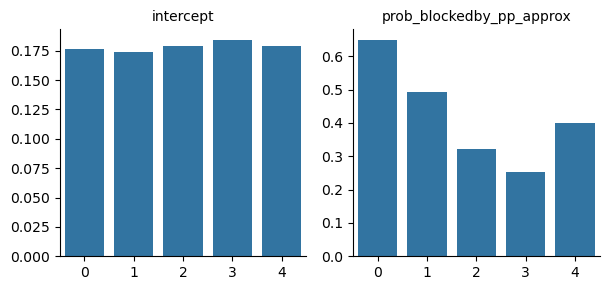

In [126]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_prob_blockedby_pp_onlyq_lm_cv_coeff.png")
Image(filename=figures_path) 

**TODO** Dig into the lasso model for prob_blockedby_pp to try to make sense of the coefficients. Why does that model fit well but the erlangc approximation is terrible.

Now, what about the ML models.

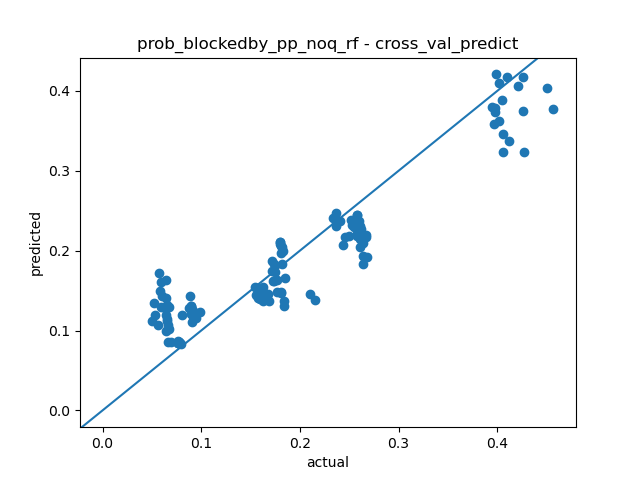

In [128]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blockedby_pp_noq_rf_cv_scatter.png")
Image(filename=figures_path) 

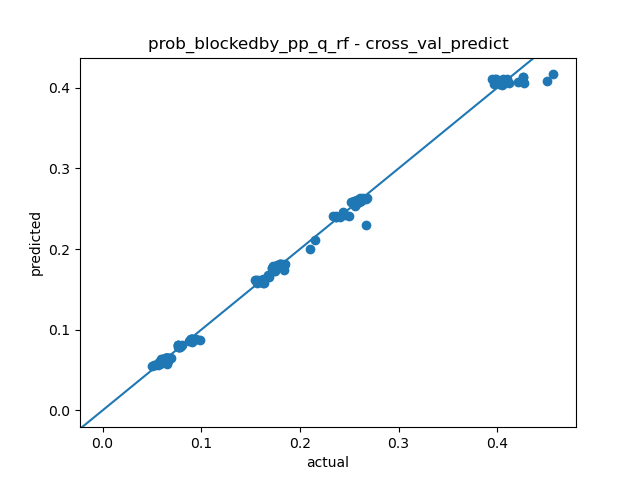

In [129]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blockedby_pp_q_rf_cv_scatter.png")
Image(filename=figures_path) 

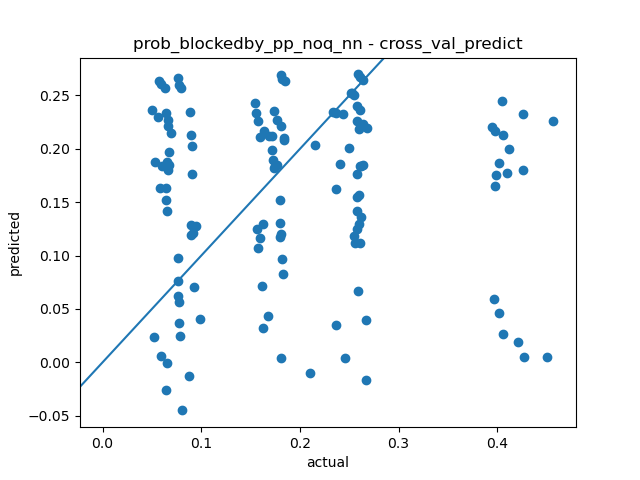

In [131]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blockedby_pp_noq_nn_cv_scatter.png")
Image(filename=figures_path) 

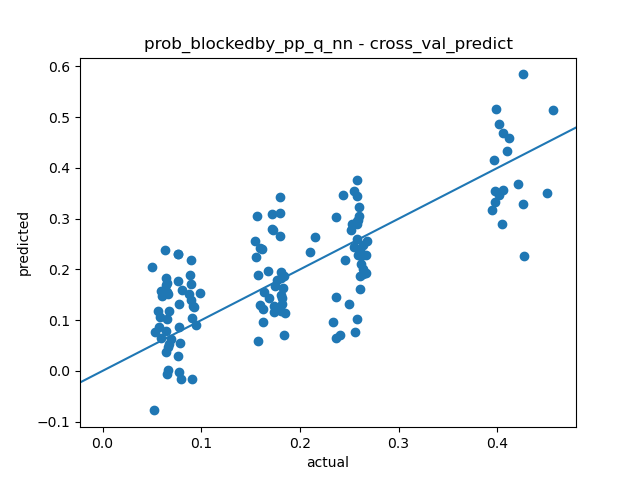

In [132]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blockedby_pp_q_nn_cv_scatter.png")
Image(filename=figures_path) 

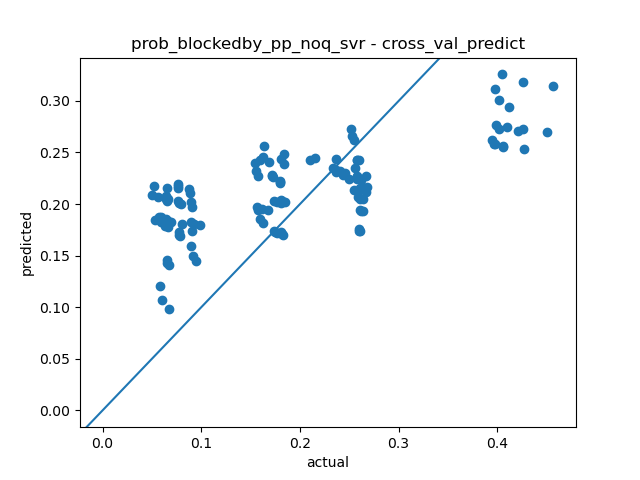

In [133]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blockedby_pp_noq_svr_cv_scatter.png")
Image(filename=figures_path) 

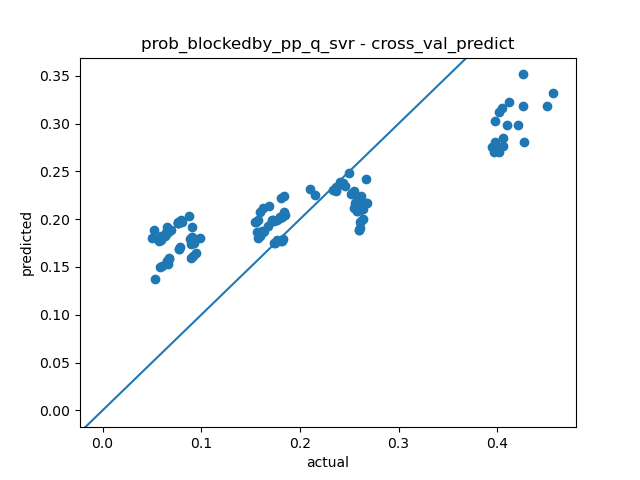

In [134]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_prob_blockedby_pp_q_svr_cv_scatter.png")
Image(filename=figures_path) 

### Conditional mean blocked time

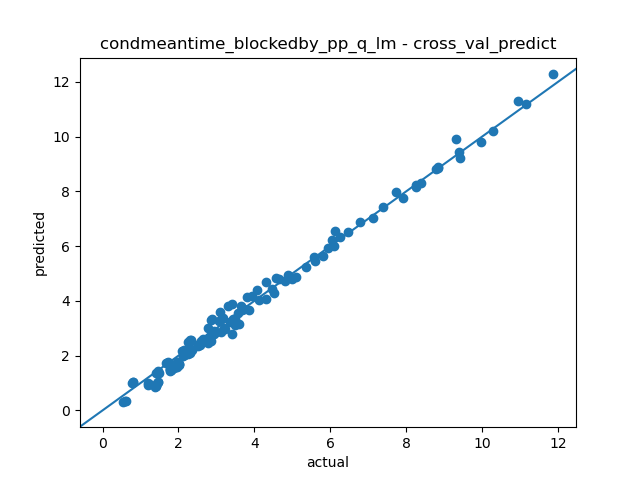

In [139]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_condmeantime_blockedby_pp_q_lm_cv_scatter.png")
Image(filename=figures_path) 

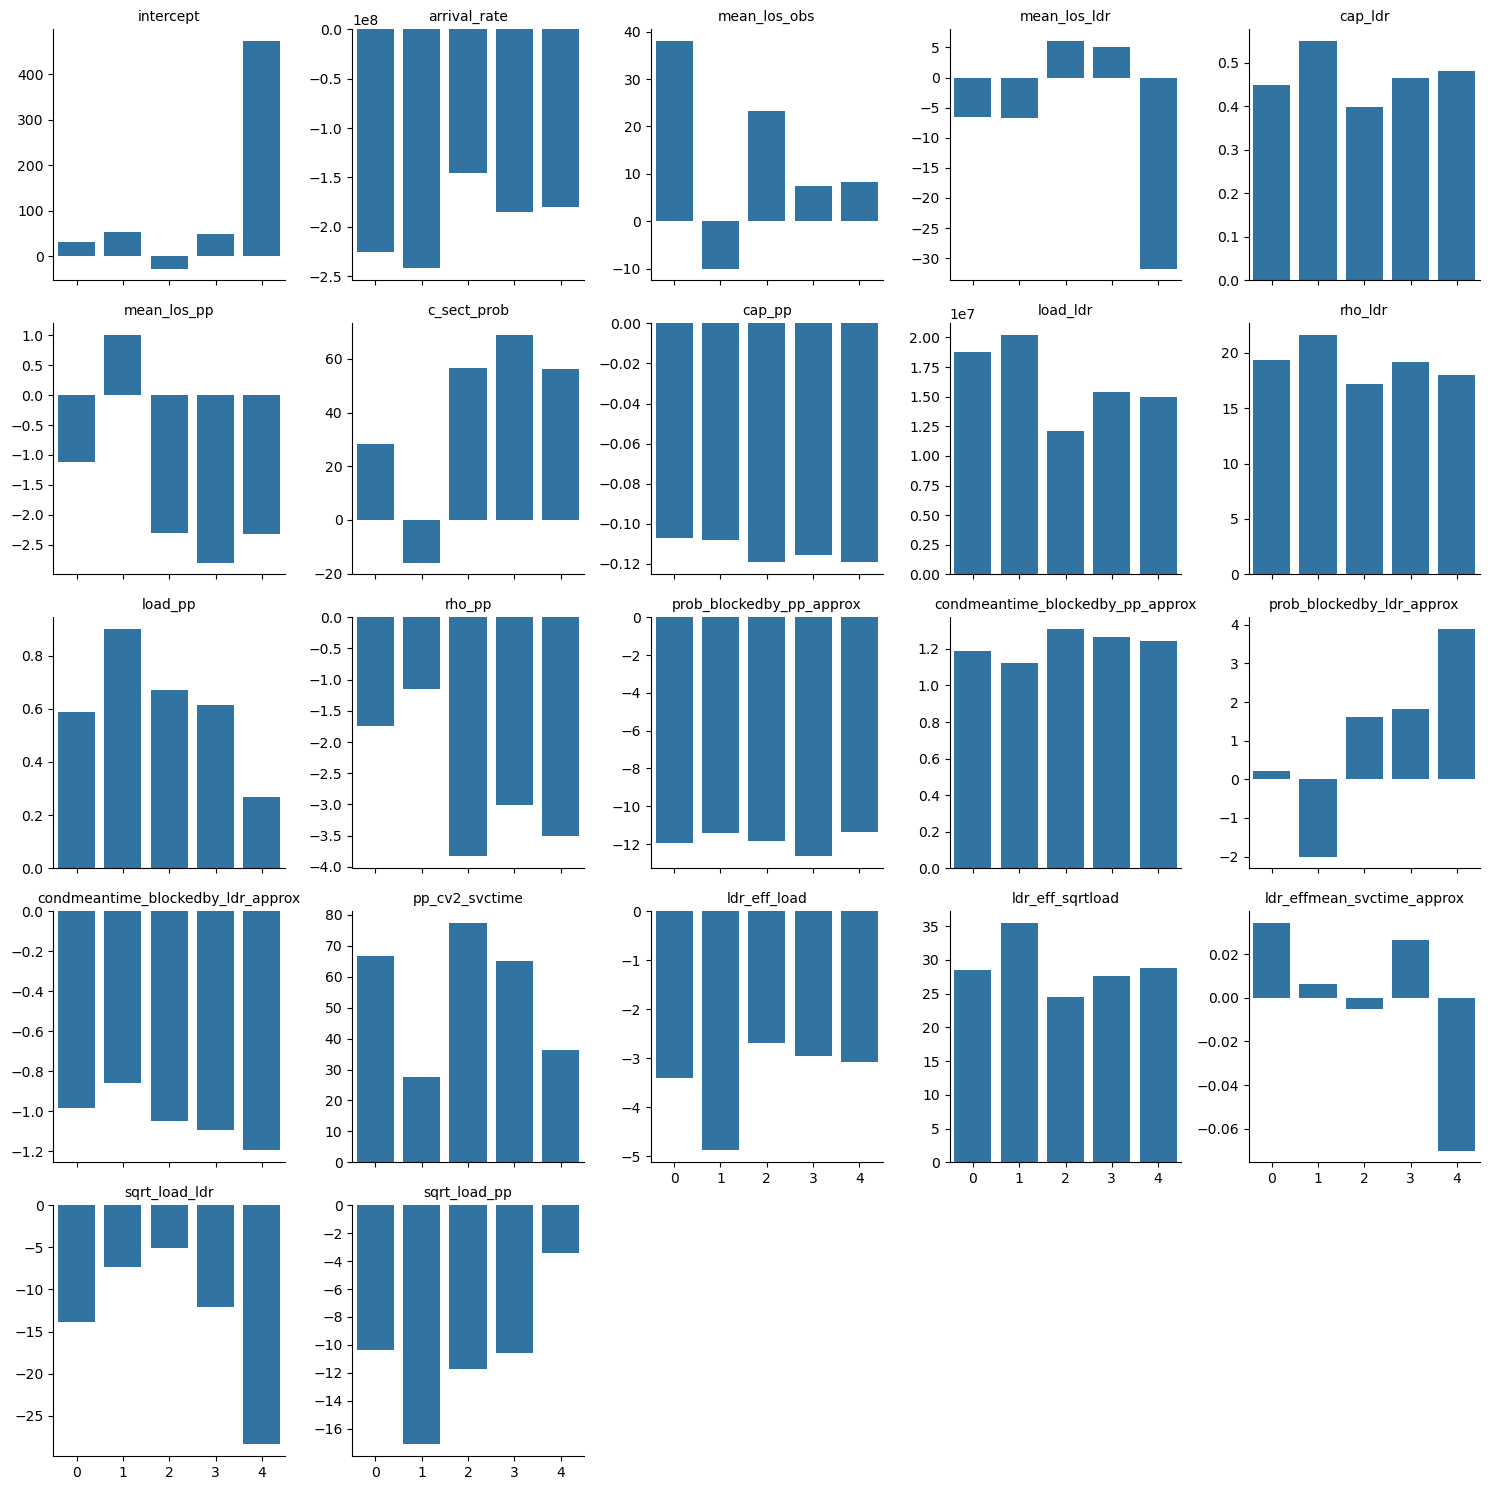

In [140]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_condmeantime_blockedby_pp_q_lm_cv_coeff.png")
Image(filename=figures_path) 

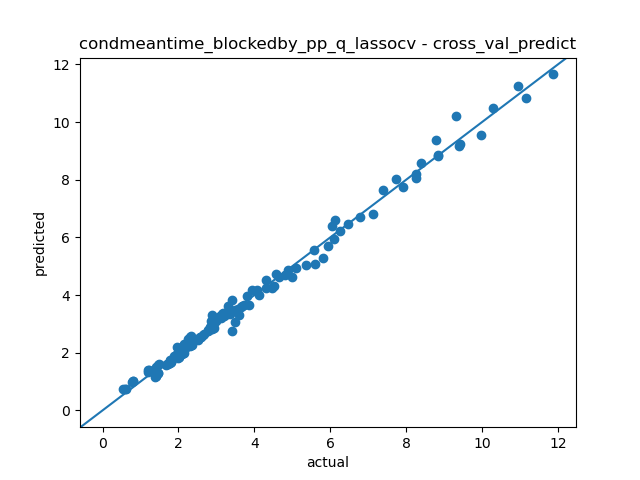

In [141]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_condmeantime_blockedby_pp_q_lassocv_cv_scatter.png")
Image(filename=figures_path) 

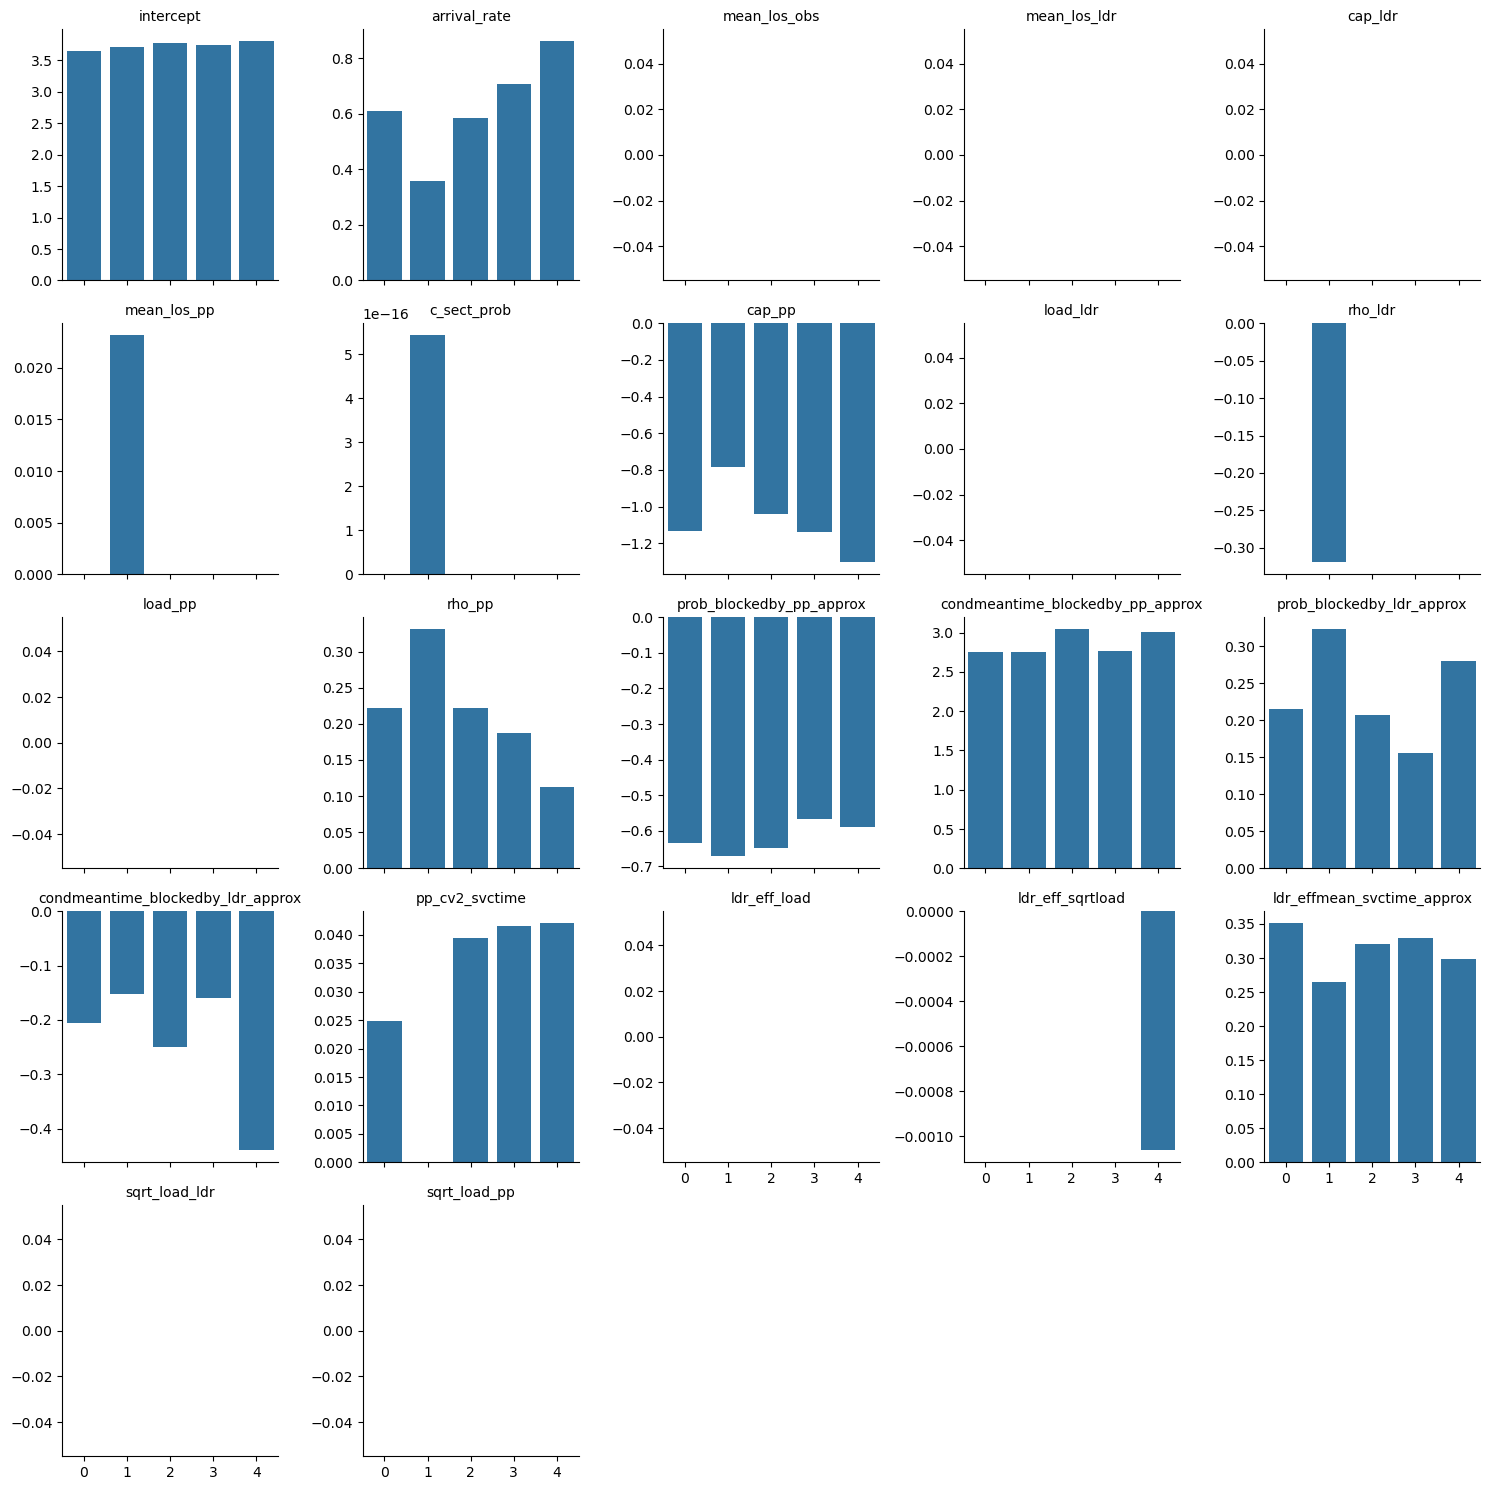

In [142]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_condmeantime_blockedby_pp_q_lassocv_cv_coeff.png")
Image(filename=figures_path) 

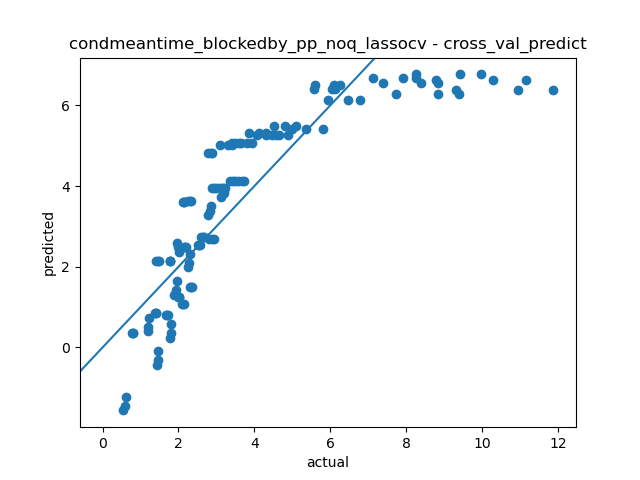

In [143]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_condmeantime_blockedby_pp_noq_lassocv_cv_scatter.png")
Image(filename=figures_path) 

And again, the basicq and q inputs help immensely.

## Obs

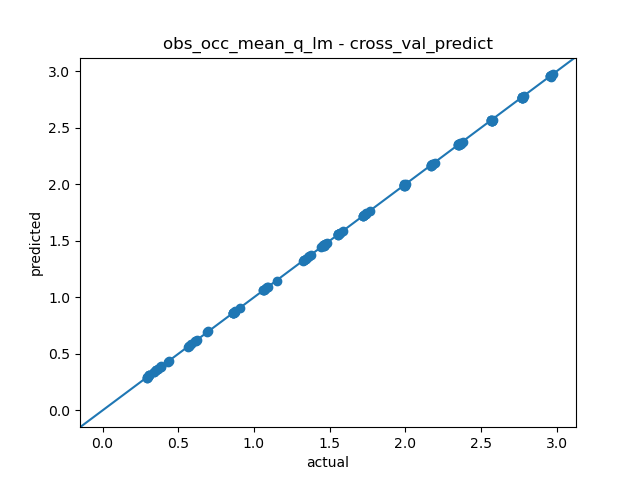

In [144]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_q_lm_cv_scatter.png")
Image(filename=figures_path) 

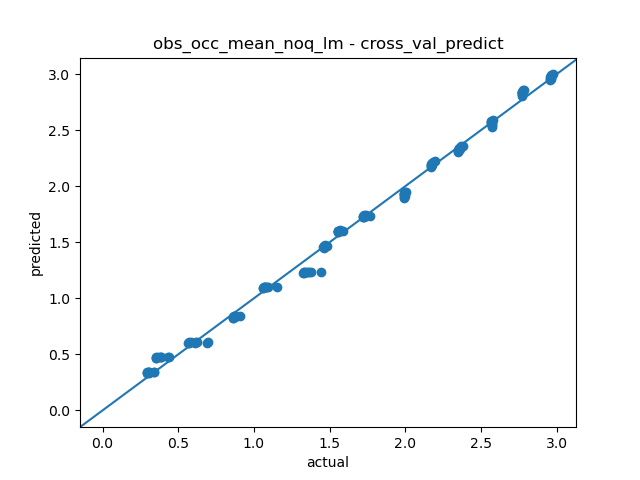

In [145]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

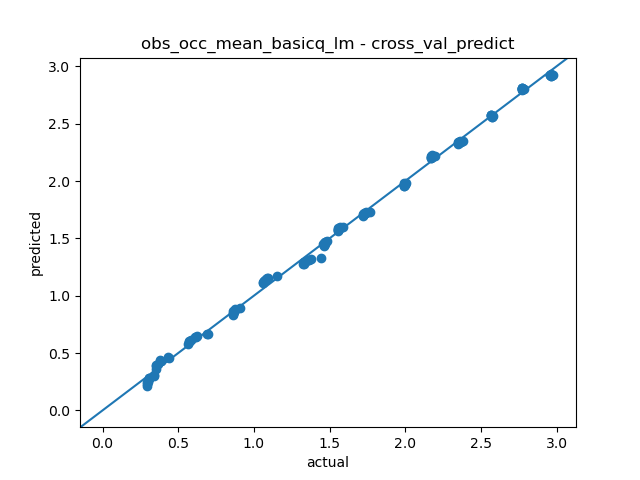

In [146]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

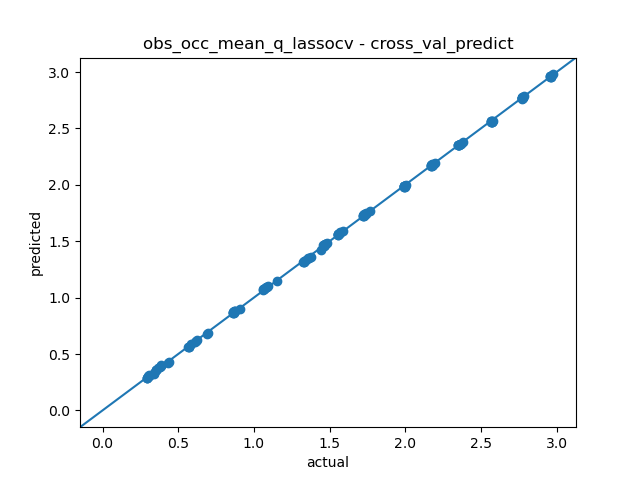

In [147]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_q_lassocv_cv_scatter.png")
Image(filename=figures_path) 

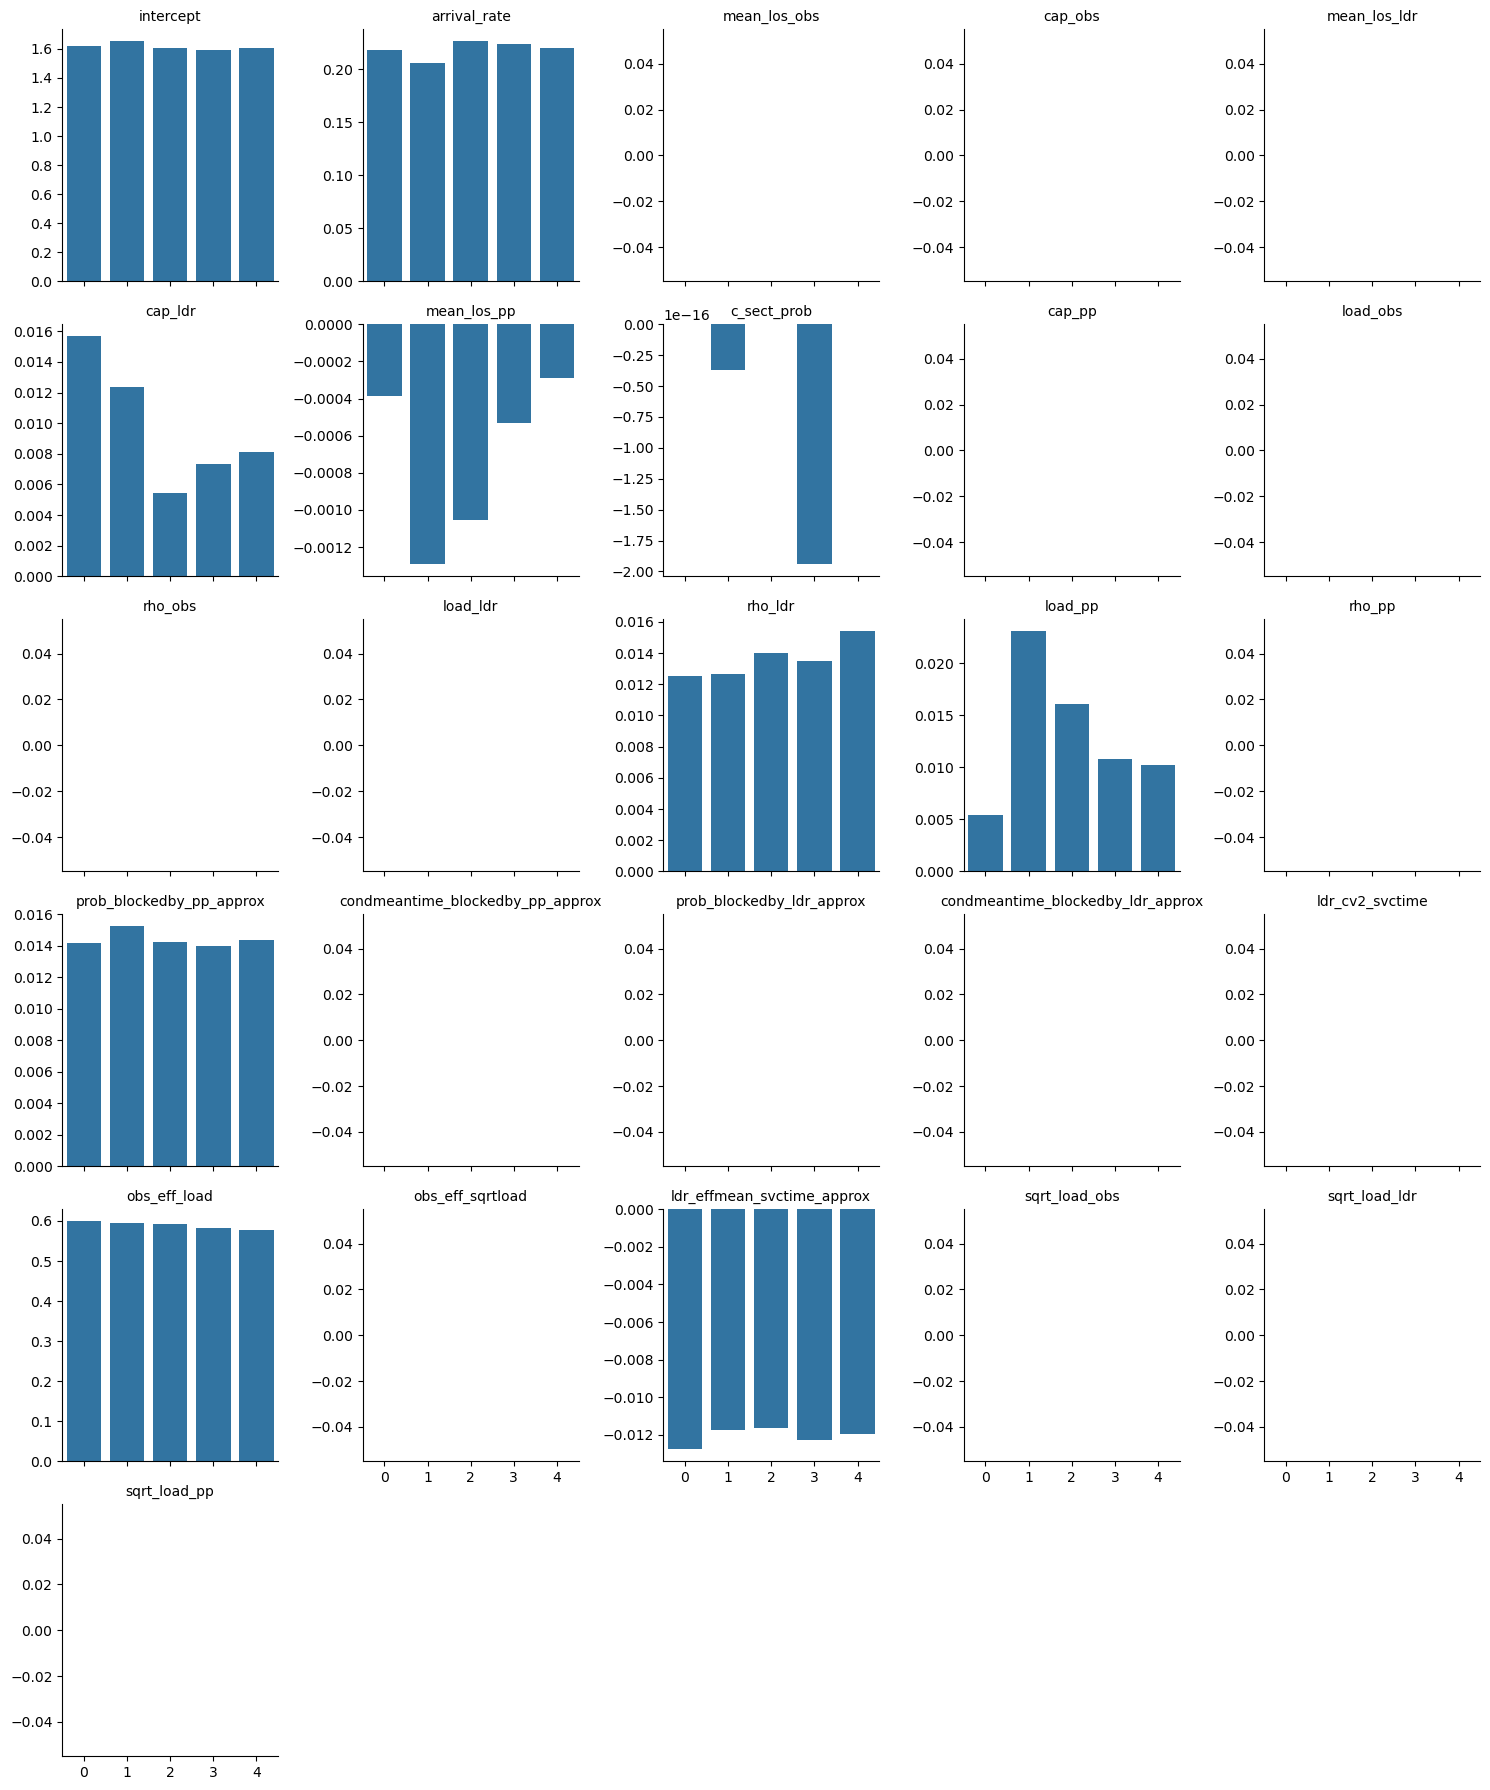

In [149]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_q_lassocv_cv_coeff.png")
Image(filename=figures_path) 

## Debugging obs poly model fits
They are way off for q and basicq while noq fits great. What's wrong?

Seems if it was the data files we'd have bad fits above for lm and lasso.

Is it a scaling issue leading to overfitting?

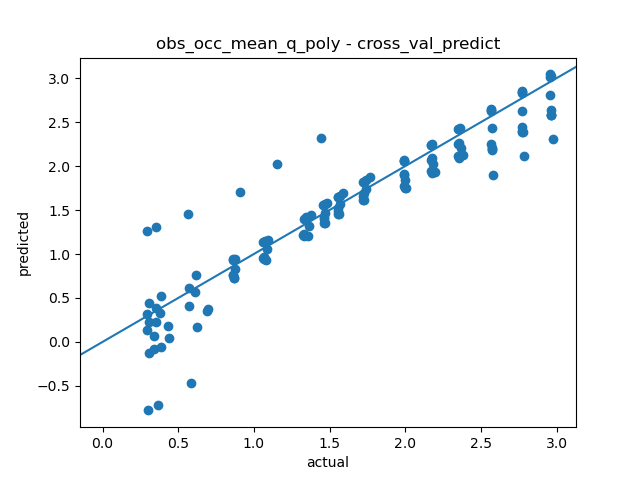

In [150]:


figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_q_poly_cv_scatter.png")
Image(filename=figures_path) 

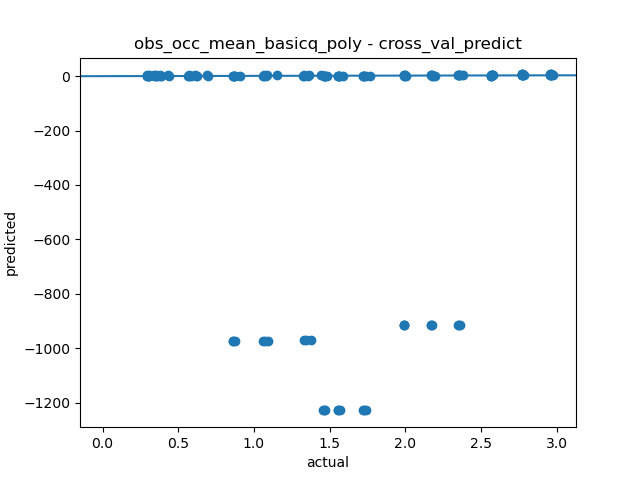

In [151]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_basicq_poly_cv_scatter.png")
Image(filename=figures_path) 

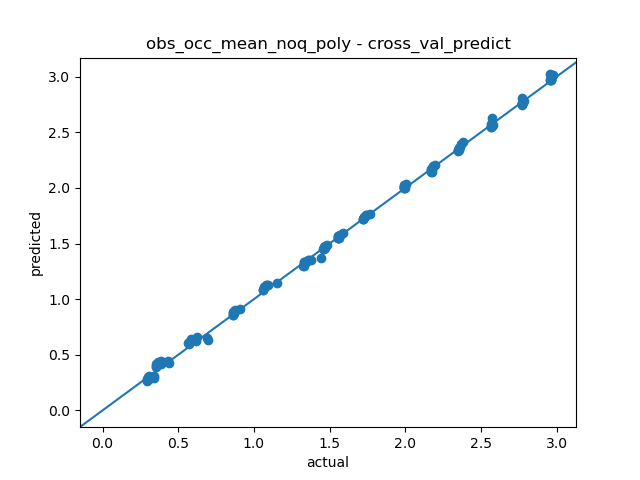

In [152]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_noq_poly_cv_scatter.png")
Image(filename=figures_path) 

What about the ML models?

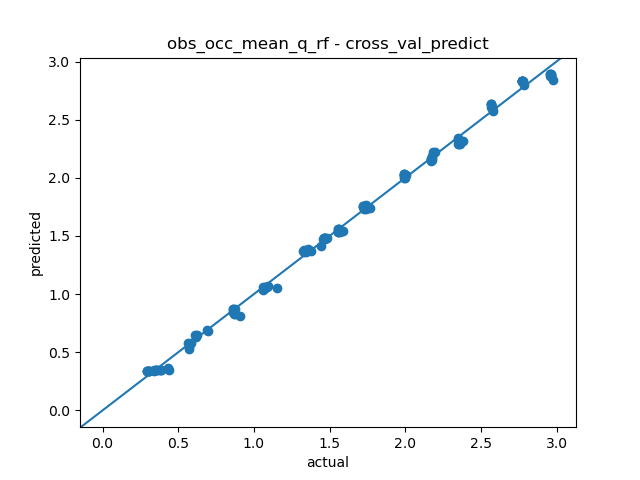

In [153]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_q_rf_cv_scatter.png")
Image(filename=figures_path) 

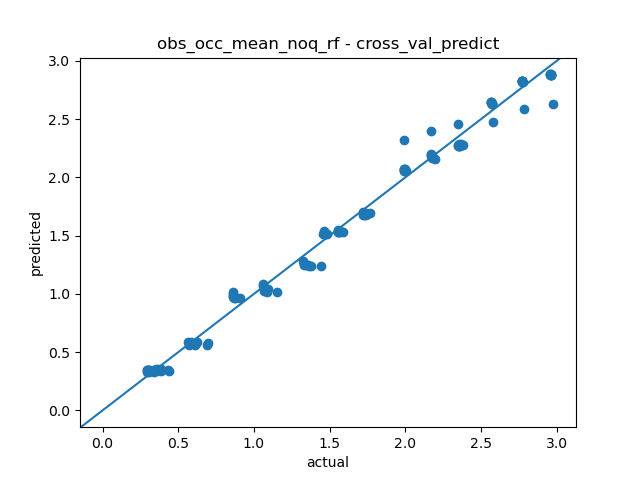

In [154]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_noq_rf_cv_scatter.png")
Image(filename=figures_path) 

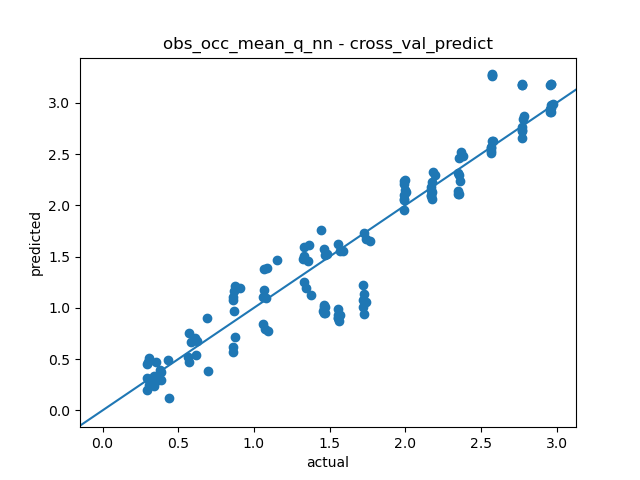

In [155]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_q_nn_cv_scatter.png")
Image(filename=figures_path) 

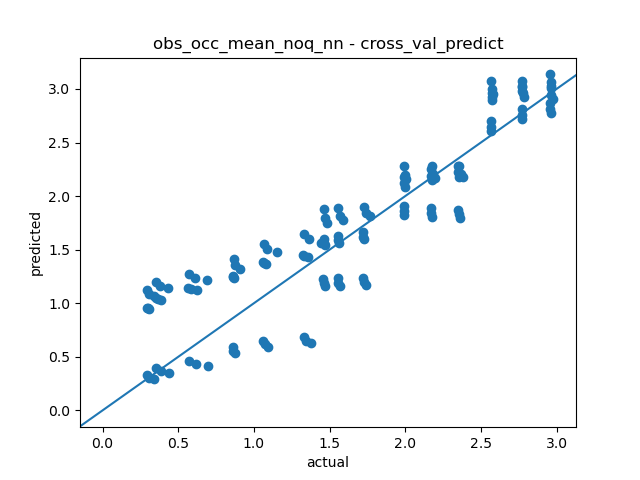

In [156]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_noq_nn_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
X_pp_basicq = pd.read_csv('data/X_pp_basicq_exp11.csv', index_col=0)

In [ ]:
X_pp_basicq.info()

In [ ]:
X_pp_load_sqrtload = X_pp_basicq.loc[:, ['load_pp', 'sqrt_load_pp']]

In [ ]:
y_pp_occ_mean = pd.read_csv('data/y_pp_occ_mean_exp11.csv', index_col=0, squeeze=True)
y_pp_occ_p95 = pd.read_csv('data/y_pp_occ_p95_exp11.csv', index_col=0, squeeze=True)

In [ ]:
pp_occ_p95_sqrtload_lm_results = crossval_summarize_mm('pp_occ_p95_sqrtload_lm', 
                                                      'pp', 'occ_p95', X_pp_load_sqrtload, y_pp_occ_p95, 
                                                      scale=False, flavor='lm', fit_intercept=False)
pp_occ_p95_sqrtload_lm_results['coeffs_df']

In [ ]:
pp_occ_p95_sqrtload_lm_results.keys()

In [ ]:
pp_occ_p95_sqrtload_lm_results['fitplot']

In [ ]:
pp_occ_mean_load_lm_results = crossval_summarize_mm('pp_occ_mean_load_lm', 
                                                      'pp', 'occ_mean', X_pp_load_sqrtload, y_pp_occ_mean, 
                                                      scale=False, flavor='lm', fit_intercept=False)
pp_occ_mean_load_lm_results['coeffs_df']

In [ ]:
pp_occ_mean_load_lassocv_results = crossval_summarize_mm('pp_occ_mean_load_lassocv', 
                                                      'pp', 'occ_mean', X_pp_load_sqrtload, y_pp_occ_mean, 
                                                      scale=False, flavor='lassocv', fit_intercept=False)
pp_occ_mean_load_lassocv_results['coeffs_df']

In [ ]:
pp_occ_mean_load_lassocv_results['fitplot']

In [ ]:
pp_occ_mean_load_lm_results['fitplot']

A bit of strangeness with scaling. The model above used scaling=False and things look good in that load is near 1 as expected. However, if we scale... (which we should since it's lasso)

In [ ]:
pp_occ_mean_load_lassocv_scaled_results = crossval_summarize_mm('pp_occ_mean_load_lassocv', 
                                                      'pp', 'occ_mean', X_pp_load_sqrtload, y_pp_occ_mean, 
                                                      scale=True, flavor='lassocv', fit_intercept=False)
pp_occ_mean_load_lassocv_scaled_results['coeffs_df']

In [ ]:
pp_occ_mean_load_lassocv_scaled_results['scaling']

Hmm, not really sure how to interpret this. Am I handling the fit_intercept argument correctly in the code? I appear to be.

In [ ]:
pp_occ_mean_load_lassocv_results['scaling']